# Lab 3: CRISP-DM Capstone
## Association Rule Mining, Clustering, or Collaborative Filtering

### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<a id="top"></a>
## Contents
* Business Understanding
* Data Understanding
    * <a href="#data1">Data Understanding 1</a>
    * <a href="#data2">Data Understanding 2</a>
* Modeling and Evaluation
    * <a href="#Model1">Train and Adjust Parameters</a>
    * <a href="#Model2">Evaluate and Compare</a>
    * <a href="#Model3">Visualize Results</a>
    * <a href="#Model4">Summarize the Ramifications</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>


In [1]:
# Display plots below cells
%matplotlib notebook

# Turn off annoying warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pprint
import pandas as pd
import numpy as np
import yellowbrick as yb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from pprint import pprint
from time import time
from datetime import datetime
from sklearn import metrics as mt
from sklearn import neighbors
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile, f_regression, mutual_info_regression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, mean_absolute_error, make_scorer, mean_squared_error, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer, scale
from sklearn.svm import LinearSVC, NuSVC, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier, RidgeClassifier, LinearRegression
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV, cross_val_score
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ClassPredictionError, ROCAUC
from yellowbrick.features import Rank1D, Rank2D, RFECV
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [3]:
# Show all columns/rows in output
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [4]:
def scoreRF(X, y, cLabels):
    acc = cross_val_score(cls, X, y = y, cv = cv, scoring = 'accuracy', n_jobs=-1)
    if len(np.unique(cLabels)) > 1:
        sil = silhouette_score(dfDropped[featCols], cLabels)
    else:
        sil = -2
    result = {'mean': acc.mean(), 'std': acc.std(), 'sil': sil}
    
    return result

def scoreExtremeRF(X, y, cLabels):
    acc = cross_val_score(cls, X, y = y, cv = cv, scoring = 'accuracy', n_jobs=-1)
    if len(np.unique(cLabels)) > 1:
        sil = silhouette_score(dfExtremes[featCols], cLabels)
    else:
        sil = -2
    result = {'mean': acc.mean(), 'std': acc.std(), 'sil': sil}
    
    return result

### Supporting Functions

In [5]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
# cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"

dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets


# We need to explain why we are focused on Q1 and Q4. Where does this go? Under data understanding ahead of Clustering??

#### Determine the 25% and 75% quartile. 

<IPython.core.display.Javascript object>


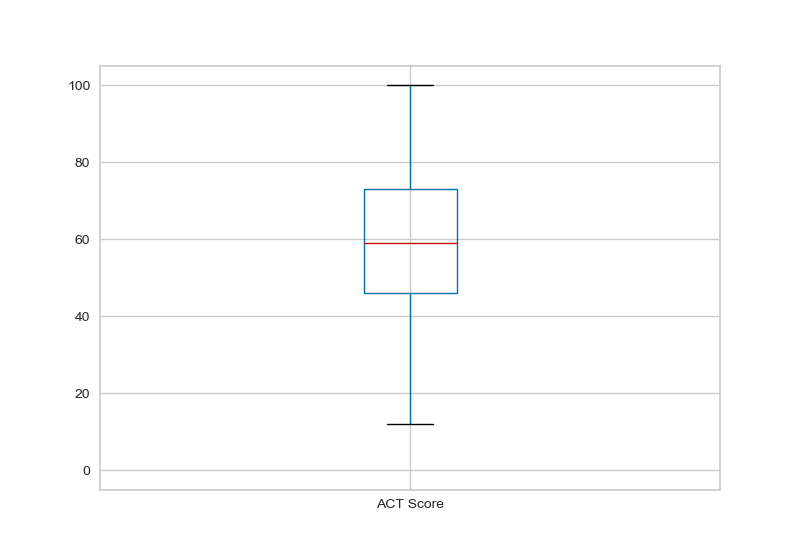

In [8]:
fig = plt.figure()
ax = fig.add_subplot()

dfPublicHS.boxplot(column=['ACT Score'])
qSplit = dfPublicHS['ACT Score'].quantile([.25, .50, .75, 1])

#### We want to explore the extremes

In [11]:
dfDropped = dfPublicHS
dfDropped["Q25"] = np.where(dfPublicHS['ACT Score'] <= qSplit[.25], 1.0, 0.0)
dfDropped["Q50"] = np.where(dfPublicHS['ACT Score'] <= qSplit[.50], 1.0, 0.0)
dfDropped["Q75"] = np.where(dfPublicHS['ACT Score'] <= qSplit[.75], 1.0, 0.0)
dfDropped["Q100"] = np.where(dfPublicHS['ACT Score'] <= qSplit[1], 1.0, 0.0)

<a href="#top">Back to Top</a> 
## Business Understanding (10 points total)

<span style="color: blue">Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?</span>


### Data Collection Overview
The team selected data from the Belk Endowment Educational Attainment Data for North Carolina Public Schools, which contains the North Carolina Public Schools Report Card as well as the Statistical Profiles Databases. This data was compiled by Dr. Jake Drew from original sources provided by the Public Schools of North Carolina (http://ncpublicschools.org), and the compilation, research, and analysis of the educational attainment data was funded by the John M. Belk Endowment (JMBE).

JMBE’s mission is focused on postsecondary education in North Carolina to help underrepresented students access and complete postsecondary education and be better prepared for entering the workforce. The educational attainment data set contains comprehensive statistics, demographics, and achievement metrics about North Carolina public, charter, and alternative elementary, middle, and high schools. This wealth of data is the foundation for research to help JMBE understand trends and improve postsecondary pathways in the state.

Our team has selected the 2017 high school data and utilized the machine learning data set prepared by Dr. Drew for analysis. Throughout the semester, we have been exploring the relationship between enrollment in postsecondary education within 16 months of high school graduation and teacher metrics related to teacher education, licensing, and certification, in addition to years of experience. This is important to help identify both positive and negative factors influencing students’ enrollment decisions and understand how educators can impact the pipeline to higher education.

Using the insights gained throughout the semester, our team has discovered that the ACT Score of a school strongly influences the percentage of students that enroll in post-secondary education [ANY RESULTS FROM PRIOR LABS TO QUANTIFY THIS!!??]. Now, we want to understand what factors are impacting ACT scores at the school level, which is the focus of the analysis in this lab. Our goals are to [WHAT!!??? – accurately classify schools into one of four ACT score quadrants…??]

### Algorithm Effectiveness
The team is using a two-pronged approach to mine the ACT data, starting with cluster analysis and then employing Random Forest for classification. Depending on the model, there are different metrics that can be used to analyze the effectiveness and predictive capability, and the most common metrics are outlined below. 

### *Clustering Algorithm*

#### Silhouette Analysis
Silhouette analysis is a method used to understand the validity and interpretation of clustering by balancing cohesion (how closely related objects are in a cluster) and separation (how distinct or well-separated a cluster is from other clusters). It measures the separation distance between resulting clusters, or how close each point in one cluster is to points in neighboring clusters. The metric, known as silhouette coefficients, range from -1 to 1. A coefficient of 0 indicates that the sample is either very close or completely aligned with the decision boundary between two neighboring clusters; a negative value indicates that samples may have been assigned to incorrect clusters. A positive value is ideal, with 1 being the optimal value. 

*Citations*:<br>
•	https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html<br>
•	https://en.wikipedia.org/wiki/Silhouette_(clustering)<br>
•	Tan, Pang-Ning, Steinbach, Michael, and Kumar, Vipin (2006), Introduction To Data Mining (1st ed.), Boston, MA: Person Education.

### *Classification Algorithms*

#### Confusion Matrix
The confusion matrix is a table that summarizes the performance of a classification model based on the count of test records that are correctly and incorrectly predicted by the model. This summary becomes the basis to calculate additional metrics such as accuracy, precision, recall, and the F-Score. 

| CONFUSION MATRIX 	| Predicted Yes  | Predicted No        	|
|------------------	|---------------------	|---------------------	|
| Actual Yes       	| True Positive (TP)  	| False Negative (FN) 	|
| Actual No        	| False Positive (FP) 	| True Negative (TN)  	|

#### Accuracy
Accuracy is a typical measurement used to evaluate classification models and is consider to be a good measure despite a few limitations. It is calculated by dividing the number of correct predictions by the total number of predictions, or TP + TN / TP + TN + FP + FN. The error rate is essentially the opposite of accuracy and looks at incorrect predictions. Most classification algorithms seek models that attain the highest accuracy, or equivalently, the lowest error rate when applied to the test set. 

One obvious limitation of accuracy is that it ignores the cost of misclassification, and this is particularly evident when the algorithm is trying to predict on imbalanced data sets. This can be addressed by looking at other metrics as part of the evaluation process.

#### Precision
Precision is a widely used classification metric where the successful detection of one class is more important than another. It is a cost-sensitive measure for the fraction of actual positive records in the group that the classifier declared in the positive class. The calculation for precision is TP / TP + FP. Higher precision means lower false positives, and the metric tends to be biased toward true positives. A good model will maximize precision.

#### Recall
Similar to precision, recall is also a widely used cost-sensitive classification metric. It measures the fraction of positive examples correctly predicted by the model, where large recall measures have few positive examples misclassified as negative, or lower false negatives. The calculation is TP / TP + FN, and the measure penalizes the model when it yields a negative when the true result is positive. Again, a good model will maximize recall. 

#### F-Score
Precision and recall can be summarized into the F-score metric (also known as the F-1 measure or F-measure). Generally, this score is a weighted accuracy measure that takes into account both precision and recall. It is calculated as the harmonic mean between the two: 2 x TP / 2 x TP + FP + FN. This too is a metric to maximize; a high value F-score indicates that precision and recall are reasonably high.  

*Citation*:<br>
•	Tan, Pang-Ning, Steinbach, Michael, and Kumar, Vipin (2006), Introduction To Data Mining (1st ed.), Boston, MA: Person Education.

### Cross Validation
Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

NW QUESTIONS:
 - How did we use cross validation? What was our methodology and reasoning? K-fold CV, Stratified K-fold CV, another method?

*Citation*:<br>
•	https://towardsdatascience.com/cross-validation-in-machine-learning-72924a69872f


# PLEASE DROP NOTES ABOUT CV here for me

<a href="#top">Back to Top</a> 
## Data Understanding (20 points total)
<a id="data1"></a>
### Data Understanding 1 (10 points)

<span style="color: blue">Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?</span>

The data for our analysis is from the Belk Endowment Educational Attainment Data Repository for North Carolina Public Schools. The data contains information about "public, charter, and alternative schools in the State of North Carolina." We are using Dr. Jake Drew's NC Education Data available on GitHub: https://github.com/jakemdrew/EducationDataNC. 

The Machine Learning Datasets created by Dr. Drew have already been preprocessed for machine learning and have gone through the following processes (reference: http://nbviewer.jupyter.org/github/jakemdrew/EducationDataNC/blob/master/2017/Machine%20Learning%20Datasets/Source%20Code/PublicHighSchools2017_ML.ipynb)
1. Missing student body racial compositions are imputed using district averages.
2. Columns that have the same value in every single row are deleted.
3. Columns that have a unique value in every single row (all values are different) are deleted.
4. Empty columns (all values are NA or NULL) are deleted.
5. Numeric columns with more than the percentage of missing values specified by the *missingThreshold* parameter.
6. Remaining numeric, non-race columns with missing values are imputed / populated with 0. In  many cases, schools are not reporting values when they are zero. However, mean imputation or some other more sophisticated strategy might be considered here.
7. Categorical / text based columns with > *uniqueThreshold* unique values are deleted.
8. All remaining categorical / text based columns are one-hot encoded. In categorical columns, one-hot encoding creates one new boolean / binary field per unique value in the target column, converting all categorical columns to a numeric data type.
9. Duplicated or highly similar columns with > 95% correlation are delelted.

*Above list is from the PublicHighSchools2017_ML.ipynb Notebook*

For our analysis, we used the PublicHighSchools2017_ML.csv file. This file only contains information regarding public high schools in North Carolina for the 2016-2017 school year.

#### Data Preprocessing

We replaced all non-alphanumeric characters with underscores.

In [12]:
# Replace all non alphanumeric characters with underscores
dfPublicHS.columns = dfPublicHS.columns.str.replace(r'\W', "_")

We changed all data types as floats since some libraries only work with floats. We are also treating the unit_code column as a string.

In [13]:
# Change all columns to floats since some libraries only work with floats
dfPublicHS = dfPublicHS.astype(float)

# Treat unit_code as a string
dfPublicHS["unit_code"] = dfPublicHS.astype({"unit_code": str})

We decided to drop any remaining variables related to the ACT such as ACT benchmarks and individual subject scores to not bias our model. Doing this also reduces multicollinearity.

In [14]:
#want to delete any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dfDropped = dfPublicHS

temp = dfDropped['ACT_Score']

dropCols = dfDropped.filter(regex = r'ACT')

dfDropped.drop(dropCols, axis = 1, inplace = True)

dfDropped['ACT_Score'] = temp

This is a list of columns that were deleted. The ACT score was put back into the dfDropped data frame.

In [15]:
#list of all the columns that were deleted (note that ACT Score was put back into dataframe that is being used)
dropCols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 470 entries, 0 to 469
Data columns (total 87 columns):
ACT_Score                                   470 non-null float64
ACT_WorkKeys_Score                          470 non-null float64
ACTMath_ACTBenchmark_All                    470 non-null float64
ACTScience_ACTBenchmark_All                 470 non-null float64
ACTWorkKeys_SilverPlus_All                  470 non-null float64
ACTWriting_ACTBenchmark_All                 470 non-null float64
ACTCompositeScore_UNCMin_Female             470 non-null float64
ACTEnglish_ACTBenchmark_Female              470 non-null float64
ACTMath_ACTBenchmark_Female                 470 non-null float64
ACTReading_ACTBenchmark_Female              470 non-null float64
ACTScience_ACTBenchmark_Female              470 non-null float64
ACTWorkKeys_SilverPlus_Female               470 non-null float64
ACTCompositeScore_UNCMin_Male               470 non-null float64
ACTMath_ACTBenchmark_Male                   470 no

#### Data Definitions and Summary Statistics

Here is a summary of the dataset, with minimum and maximum values, which gives an idea of the scale and values for each variable.

In [17]:
dfDropped.describe(include='all').transpose()

count  unique    top  \
student_num                                         470.0     NaN    NaN   
lea_avg_student_num                                 470.0     NaN    NaN   
st_avg_student_num                                  470.0     NaN    NaN   
09_Size                                             470.0     NaN    NaN   
10_Size                                             470.0     NaN    NaN   
11_Size                                             470.0     NaN    NaN   
12_Size                                             470.0     NaN    NaN   
Biology_Size                                        470.0     NaN    NaN   
English_II_Size                                     470.0     NaN    NaN   
Math_I_Size                                         470.0     NaN    NaN   
lea_total_expense_num                               470.0     NaN    NaN   
lea_salary_expense_pct                              470.0     NaN    NaN   
lea_services_expense_pct                            470.0     NaN    NaN   
lea_supplies_expense_pct                            470.0     NaN    NaN   
lea_instruct_equip_exp_pct                          470.0     NaN    NaN   
lea_federal_perpupil_num                            470.0     NaN    NaN   
lea_local_perpupil_num                              470.0     NaN    NaN   
lea_state_perpupil_num                              470.0     NaN    NaN   
SPG_Score                                           470.0     NaN    NaN   
EVAAS_Growth_Score                                  470.0     NaN    NaN   
NC_Math_1_Score                                     470.0     NaN    NaN   
English_II_Score                                    470.0     NaN    NaN   
Biology_Score                                       470.0     NaN    NaN   
Passing_NC_Math_3                                   470.0     NaN    NaN   
4_Year_Cohort_Graduation_Rate_Score                 470.0     NaN    NaN   
EOCSubjects_CACR_All                                470.0     NaN    NaN   
GraduationRate_5yr_All                              470.0     NaN    NaN   
EOCBiology_CACR_Female                              470.0     NaN    NaN   
EOCEnglish2_CACR_Female                             470.0     NaN    NaN   
GraduationRate_4yr_Female                           470.0     NaN    NaN   
GraduationRate_5yr_Female                           470.0     NaN    NaN   
EOCBiology_CACR_Male                                470.0     NaN    NaN   
EOCEnglish2_CACR_Male                               470.0     NaN    NaN   
EOCMathI_CACR_Male                                  470.0     NaN    NaN   
GraduationRate_4yr_Male                             470.0     NaN    NaN   
GraduationRate_5yr_Male                             470.0     NaN    NaN   
EOCBiology_CACR_AmericanIndian                      470.0     NaN    NaN   
EOCEnglish2_CACR_AmericanIndian                     470.0     NaN    NaN   
EOCMathI_CACR_AmericanIndian                        470.0     NaN    NaN   
EOCSubjects_CACR_AmericanIndian                     470.0     NaN    NaN   
GraduationRate_4yr_AmericanIndian                   470.0     NaN    NaN   
GraduationRate_5yr_AmericanIndian                   470.0     NaN    NaN   
EOCBiology_CACR_Asian                               470.0     NaN    NaN   
EOCEnglish2_CACR_Asian                              470.0     NaN    NaN   
EOCMathI_CACR_Asian                                 470.0     NaN    NaN   
EOCSubjects_CACR_Asian                              470.0     NaN    NaN   
GraduationRate_4yr_Asian                            470.0     NaN    NaN   
GraduationRate_5yr_Asian                            470.0     NaN    NaN   
EOCBiology_CACR_Black                               470.0     NaN    NaN   
EOCEnglish2_CACR_Black                              470.0     NaN    NaN   
EOCMathI_CACR_Black                                 470.0     NaN    NaN   
EOCSubjects_CACR_Black                              470.0     NaN    NaN   
GraduationRate_4yr_Black

Here is a description of each variable in our dataset. The data table column refers to the raw csv file where it can be found. Please refer to the README file from Dr. Drew for URLs to the data sources: https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Raw%20Datasets/README.md



| Column Name                                           | Description                                                                                                                                         | Data Table                     | 
|-------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------| 
| student_num                                           | Number of students at school level (school size)                                                                                                    | Profile                        | 
| lea_avg_student_num                                   | Average school size within the LEA                                                                                                                  | Profile                        | 
| st_avg_student_num                                    | Average school size within the state                                                                                                                | Profile                        | 
| 09_Size                                               | Average grade size for school                                                                                                                       | Profile Metric                 | 
| 10_Size                                               | Average grade size for school                                                                                                                       | Profile Metric                 | 
| 11_Size                                               | Average grade size for school                                                                                                                       | Profile Metric                 | 
| 12_Size                                               | Average grade size for school                                                                                                                       | Profile Metric                 | 
| Biology_Size                                          | Average class size for school                                                                                                                       | Profile Metric                 | 
| English_II_Size                                       | Average class size for school                                                                                                                       | Profile Metric                 | 
| Math_I_Size                                           | Average class size for school                                                                                                                       | Profile Metric                 | 
| lea_total_expense_num                                 | Total expense (Dollars Spent) at LEA level                                                                                                          | Funding                        | 
| lea_salary_expense_pct                                | Percent of expense spent on Salaries at LEA level                                                                                                   | Funding                        | 
| lea_services_expense_pct                              | Percent of expense spent on Services at LEA level                                                                                                   | Funding                        | 
| lea_supplies_expense_pct                              | Percent of expense spent on Supplies at LEA level                                                                                                   | Funding                        | 
| lea_instruct_equip_exp_pct                            | Percent of expense spent on Instructional Equipment at LEA level                                                                                    | Funding                        | 
| lea_federal_perpupil_num                              | Federal expense per pupil at LEA level                                                                                                              | Funding                        | 
| lea_local_perpupil_num                                | Local expense per pupil at school level                                                                                                             | Funding                        | 
| lea_state_perpupil_num                                | State expense per pupil at LEA level                                                                                                                | Funding                        | 
| SPG_Score                                             | School Performance Grade score                                                                                                                      | SPG                            | 
| EVAAS_Growth_Score                                    | Education Value-Added Assessment System Growth score                                                                                                | SPG                            | 
| NC_Math_1_Score                                       | Average score for NC Math 1                                                                                                                         | SPG                            | 
| English_II_Score                                      | Average score for English II                                                                                                                        | SPG                            | 
| Biology_Score                                         | Average score for Biology                                                                                                                           | SPG                            | 
| Passing_NC_Math_3                                     | Average score for Passing NC Math 3                                                                                                                 | SPG                            | 
| 4_Year_Cohort_Graduation_Rate_Score                   | Average score for 4 year cohort graduation rate                                                                                                     | SPG                            | 
| EOCSubjects_CACR_All                                  | Average percent by school for All End of Course Subjects by College and Career Ready standard                                                       | READY (acctdrilldwn)           | 
| GraduationRate_5yr_All                                | Graduation Rate for 5 year (Extended)                                                                                                               | READY (acctdrilldwn)           | 
| EOCBiology_CACR_Female                                | EOC Biology Score by School/CACR - Female                                                                                                           | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_Female                               | EOC English 2 Score by School/CACR - Female                                                                                                         | READY (acctdrilldwn)           | 
| GraduationRate_4yr_Female                             | Female Graduation Rate for 4 year (Standard)                                                                                                        | READY (acctdrilldwn)           | 
| GraduationRate_5yr_Female                             | Female Graduation Rate for 5 year (Extended)                                                                                                        | READY (acctdrilldwn)           | 
| EOCBiology_CACR_Male                                  | EOC Biology Score by School/CACR - Male                                                                                                             | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_Male                                 | EOC English 2 Score by School/CACR - Male                                                                                                           | READY (acctdrilldwn)           | 
| EOCMathI_CACR_Male                                    | EOC Math 1 Score by School/CACR - Male                                                                                                              | READY (acctdrilldwn)           | 
| GraduationRate_4yr_Male                               | Male Graduation Rate for 4 year                                                                                                                     | READY (acctdrilldwn)           | 
| GraduationRate_5yr_Male                               | Male Gradation Rate for 5 year                                                                                                                      | READY (acctdrilldwn)           | 
| EOCBiology_CACR_AmericanIndian                        | EOC Biology Score by School/CACR -Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_AmericanIndian                       | EOC English 2 Score by School/CACR - Ethnicity                                                                                                      | READY (acctdrilldwn)           | 
| EOCMathI_CACR_AmericanIndian                          | EOC Math 1 Score by School/CACR - Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_AmericanIndian                       | EOC Subjects by School/CACR - Ethnicity                                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_4yr_AmericanIndian                     | Graduation Rate for 4 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| GraduationRate_5yr_AmericanIndian                     | Graduation Rate for 5 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| EOCBiology_CACR_Asian                                 | EOC Biology Score by School/CACR -Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_Asian                                | EOC English 2 Score by School/CACR - Ethnicity                                                                                                      | READY (acctdrilldwn)           | 
| EOCMathI_CACR_Asian                                   | EOC Math1 Score by School/CACR - Ethnicity                                                                                                          | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_Asian                                | EOC Subjects by School/CACR - Ethnicity                                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_4yr_Asian                              | Graduation Rate for 4 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| GraduationRate_5yr_Asian                              | Graduation Rate for 5 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| EOCBiology_CACR_Black                                 | EOC Biology Score by School/CACR -Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_Black                                | EOC English 2 Score by School/CACR - Ethnicity                                                                                                      | READY (acctdrilldwn)           | 
| EOCMathI_CACR_Black                                   | EOC Math 1 Score by School/CACR - Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_Black                                | EOC Subjects by School/CACR - Ethnicity                                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_4yr_Black                              | Graduation Rate for 4 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| GraduationRate_5yr_Black                              | Graduation Rate for 5 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| EOCBiology_CACR_Hispanic                              | EOC Biology Score by School/CACR -Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_Hispanic                             | EOC English 2 Score by School/CACR - Ethnicity                                                                                                      | READY (acctdrilldwn)           | 
| EOCMathI_CACR_Hispanic                                | EOC Math 1 Score by School/CACR - Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_Hispanic                             | EOC Subjects by School/CACR - Ethnicity                                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_4yr_Hispanic                           | Graduation Rate for 4 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| GraduationRate_5yr_Hispanic                           | Graduation Rate for 5 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| EOCBiology_CACR_TwoorMoreRaces                        | EOC Biology Score by School/CACR -Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_TwoorMoreRaces                       | EOC English 2 Score by School/CACR - Ethnicity                                                                                                      | READY (acctdrilldwn)           | 
| EOCMathI_CACR_TwoorMoreRaces                          | EOC Math 1 Score by School/CACR - Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_TwoorMoreRaces                       | EOC Subjects by School/CACR - Ethnicity                                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_4yr_TwoorMoreRaces                     | Graduation Rate for 4 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| GraduationRate_5yr_TwoorMoreRaces                     | Graduation Rate for 5 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| EOCBiology_CACR_White                                 | EOC Biology Score by School/CACR -Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_White                                | EOC English 2 Score by School/CACR - Ethnicity                                                                                                      | READY (acctdrilldwn)           | 
| EOCMathI_CACR_White                                   | EOC Math 1 Score by School/CACR - Ethnicity                                                                                                         | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_White                                | EOC Subjects by School/CACR - Ethnicity                                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_4yr_White                              | Graduation Rate for 4 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| GraduationRate_5yr_White                              | Graduation Rate for 5 year - Ethnicity                                                                                                              | READY (acctdrilldwn)           | 
| EOCBiology_CACR_EDS                                   | EOC Biology Score by School/CACR - Economically Disadvantaged                                                                                       | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_EDS                                  | EOC English 2 Score by School/CACR - Economically Disadvantaged                                                                                     | READY (acctdrilldwn)           | 
| EOCMathI_CACR_EDS                                     | EOC Math 1 Score by School/CACR - Economically Disadvantaged                                                                                        | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_EDS                                  | EOC Subjects by School/CACR - Economically Disadvantaged                                                                                            | READY (acctdrilldwn)           | 
| GraduationRate_4yr_EDS                                | Graduation Rate for 4 year - Economically Disadvantaged                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_5yr_EDS                                | Graduation Rate for 5 Year - Economically Disadvantaged                                                                                             | READY (acctdrilldwn)           | 
| EOCBiology_CACR_LEP                                   | EOC Biology Score by School/CACR - Limited English Proficient                                                                                       | READY (acctdrilldwn)           | 
| EOCBiology_GLP_LEP                                    | EOC Biology Score by School/Grade Level Proficient (GLP) - Limited English Proficiency                                                              | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_LEP                                  | EOC English 2 by School/CACR - Limited English Proficiency                                                                                          | READY (acctdrilldwn)           | 
| EOCEnglish2_GLP_LEP                                   | EOC English 2 by School/GLP - Limited English Proficiency                                                                                           | READY (acctdrilldwn)           | 
| EOCMathI_CACR_LEP                                     | EOC Math 1 by School/CACR - Limited English Proficiency                                                                                             | READY (acctdrilldwn)           | 
| EOCMathI_GLP_LEP                                      | EOC Math 1 by School/GLP - Limited English Proficiency                                                                                              | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_LEP                                  | EOC Subjects by School/CACR - Limited English Proficiency                                                                                           | READY (acctdrilldwn)           | 
| EOCSubjects_GLP_LEP                                   | EOC Subjects by School/GLP - Limited English Proficiency                                                                                            | READY (acctdrilldwn)           | 
| EOG_EOCSubjects_GLP_LEP                               | End of Grade EOC Subjects by School/GLP - Limited English Proficiency                                                                               | READY (acctdrilldwn)           | 
| GraduationRate_4yr_LEP                                | Graduation Rate for 4 Year - Limited English Proficiency                                                                                            | READY (acctdrilldwn)           | 
| GraduationRate_5yr_LEP                                | Graduation Rate for 5 Year - Limited English Proficiency                                                                                            | READY (acctdrilldwn)           | 
| EOCBiology_CACR_SWD                                   | EOC Biology Score by School/CACR - Students with Disabilities                                                                                       | READY (acctdrilldwn)           | 
| EOCBiology_GLP_SWD                                    | EOC Biology Score by School/GLP - Students with Disabilities                                                                                        | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_SWD                                  | EOC English 2 Score by School/CACR - Students with Disabilities                                                                                     | READY (acctdrilldwn)           | 
| EOCEnglish2_GLP_SWD                                   | EOC English 2 Score by School/GLP - Students with Disabilities                                                                                      | READY (acctdrilldwn)           | 
| EOCMathI_CACR_SWD                                     | EOC Math 1 Score by School/CACR - Students with Disabilities                                                                                        | READY (acctdrilldwn)           | 
| EOCMathI_GLP_SWD                                      | EOC Math 1 Score by School/GLP - Students with Disabilities                                                                                         | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_SWD                                  | EOC Subjects Score by School/CACR - Students with Disabilities                                                                                      | READY (acctdrilldwn)           | 
| EOCSubjects_GLP_SWD                                   | EOC Subjects Score by School/GLP - Students with Disabilities                                                                                       | READY (acctdrilldwn)           | 
| EOG_EOCSubjects_CACR_SWD                              | End of Grade EOC Subjects by School/CACR - Students with Disabilities                                                                               | READY (acctdrilldwn)           | 
| EOG_EOCSubjects_GLP_SWD                               | End of Grade EOC Subjects by School/GLP - Students with Disabilities                                                                                | READY (acctdrilldwn)           | 
| GraduationRate_4yr_SWD                                | Graduation Rate for 4 Year - Students with Disabilities                                                                                             | READY (acctdrilldwn)           | 
| GraduationRate_5yr_SWD                                | Graduation Rate for 5 Year - Students With Disabilities                                                                                             | READY (acctdrilldwn)           | 
| EOCBiology_CACR_AIG                                   | EOC Biology Score by School/CACR - Academically or Intellectually Gifted                                                                            | READY (acctdrilldwn)           | 
| EOCEnglish2_CACR_AIG                                  | EOC English 2 Score by School/CACR - Academically or Intellectually Gifted                                                                          | READY (acctdrilldwn)           | 
| EOCMathI_CACR_AIG                                     | EOC Math 1 Score by School/CACR - Academically or Intellectually Gifted                                                                             | READY (acctdrilldwn)           | 
| EOCSubjects_CACR_AIG                                  | EOC Subjects by School/CACR- Academically or Intellectually Gifted                                                                                  | READY (acctdrilldwn)           | 
| GraduationRate_4yr_AIG                                | Graduation Rate for 4 Year - Academically or Intellectually Gifted                                                                                  | READY (acctdrilldwn)           | 
| GraduationRate_5yr_AIG                                | Grauduation Rate for 5 Year - Academically or Intellectually Gifted                                                                                 | READY (acctdrilldwn)           | 
| CurrentYearEOC_pTarget_PctMet                         | Percentage of participation target met for Current Year EOC                                                                                         | Participation Targets Overall  | 
| MathGr10_pTarget_PctMet                               | Percentage of participation target met for Grade 10 Math                                                                                            | Participation Targets Overall  | 
| ReadingGr10_pTarget_PctMet                            | Percentage of participation target met for Grade 10 Reading                                                                                         | Participation Targets Overall  | 
| SciGr11_pTarget_PctMet                                | Percentage of participation target met for Grade 11 Science                                                                                         | Participation Targets Overall  | 
| TotalTargets_pTarget_PctMet                           | Percentage of participation target met for Total Targets                                                                                            | Participation Targets Overall  | 
| sat_avg_score_num                                     | Average SAT Score (Critical Reading plus Math) at the School Level                                                                                  | School Indicators              | 
| lea_sat_avg_score_num                                 | Average SAT Score (Critical Reading + Math) at the LEA level                                                                                        | School Indicators              | 
| sat_participation_pct                                 | Percentage of High School Seniors taking the SAT at the School Level                                                                                | School Indicators              | 
| lea_sat_participation_pct                             | Percentage of High School Seniors taking the SAT at the LEA level                                                                                   | School Indicators              | 
| ap_participation_pct                                  | Percentage of High School Students taking an AP exam at the School Level                                                                            | School Indicators              | 
| lea_ap_participation_pct                              | Pecentage of High School Students taking an AP exam at the LEA Level                                                                                | School Indicators              | 
| ap_pct_3_or_above                                     | Percentage of AP Exams with Scores of 3 or Above at the School Level                                                                                | School Indicators              | 
| lea_ap_pct_3_or_above                                 | Percentage of AP Exams with Scores of 3 or Above at the LEA Level                                                                                   | School Indicators              | 
| total_specialized_courses                             | Percent of students enrolled in at least one specialized course (CTE, AP/IB, Community College or University academic course) at the school level | Specializied Course Enrollment | 
| cte_courses                                           | Percent of students enrolled in at least one Career and Technical Education (CTE) course at the school level                                        | Specializied Course Enrollment | 
| univ_college_courses                                  | Percent of students enrolled in at least one academic course at a community college or university at the school level                               | Specializied Course Enrollment | 
| lea_total_specialized_courses                         | Percent of students enrolled in at least one specialized course (CTE, AP/IB, Community College or University academic course) at the LEA level    | Specializied Course Enrollment | 
| lea_cte_courses                                       | Percent of students enrolled in at least one Career and Technical Education (CTE) course at the LEA level                                           | Specializied Course Enrollment | 
| lea_univ_college_courses                              | Percent of students enrolled in at least one academic course at a community college or university at the LEA level                                  | Specializied Course Enrollment | 
| st_total_specialized_courses                          | Percent of students enrolled in at least one specialized course (CTE, AP/IB, Community College or University academic course) at the state level  | Specializied Course Enrollment | 
| ALL_All_Students__Total_or_Subtotal_ENROLL_sch_pct    | The percentage of students enrolled in college by school                                                                                            | College Enrollment             | 
| ECODIS_Economically_Disadvantaged_ENROLL_sch_pct      | The percentage of economically disadvantaged students enrolled in college by school                                                                 | College Enrollment             | 
| F_Female_ENROLL_sch_pct                               | The percentage of female students enrolled in college by school                                                                                     | College Enrollment             | 
| M_Male_ENROLL_sch_pct                                 | The percentage of male students enrolled in college by school                                                                                       | College Enrollment             | 
| MB_Black_ENROLL_sch_pct                               | The percentage of black male students enrolled in college by school                                                                                 | College Enrollment             | 
| MW_White_ENROLL_sch_pct                               | The percentage of white male students enrolled in college by school                                                                                 | College Enrollment             | 
| avg_daily_attend_pct                                  | Average daily attendance percentage at school level                                                                                                 | Environment                    | 
| crime_per_c_num                                       | Number of crimes or acts of violence per 100 students at School level                                                                               | Environment                    | 
| short_susp_per_c_num                                  | Short term suspensions per 100 students at school level                                                                                             | Environment                    | 
| long_susp_per_c_num                                   | Long term suspensions per 100 students at school level                                                                                              | Environment                    | 
| expelled_per_c_num                                    | Expulsions per 100 students at school level                                                                                                         | Environment                    | 
| stud_internet_comp_num                                | Ratio of students to internet connected computer at school level                                                                                    | Environment                    | 
| lea_avg_daily_attend_pct                              | Average daily attendance percentage at LEA level                                                                                                    | Environment                    | 
| lea_crime_per_c_num                                   | Number of crimes or acts of violence per 100 students at LEA level                                                                                  | Environment                    | 
| lea_short_susp_per_c_num                              | Short term suspensions per 100 students at LEA level                                                                                                | Environment                    | 
| lea_long_susp_per_c_num                               | Long term suspensions per 100 students at LEA level                                                                                                 | Environment                    | 
| lea_expelled_per_c_num                                | Expulsions per 100 students at LEA level                                                                                                            | Environment                    | 
| lea_stud_internet_comp_num                            | Ratio of students to internet connected at LEA level                                                                                                | Environment                    | 
| st_avg_daily_attend_pct                               | Average daily attendance percentage at State level                                                                                                  | Environment                    | 
| st_crime_per_c_num                                    | Number of crimes or acts of violence per 100 students at State level                                                                                | Environment                    | 
| st_short_susp_per_c_num                               | Short term supensions per 100 students at State level                                                                                               | Environment                    | 
| digital_media_pct                                     | Percentage of digital media by school                                                                                                               | Environment                    | 
| avg_age_media_collection                              | Average age of media collection by school                                                                                                           | Environment                    | 
| books_per_student                                     | Average number of books per student by school                                                                                                       | Environment                    | 
| lea_books_per_student                                 | Average number of books per student at LEA level                                                                                                    | Environment                    | 
| wap_num                                               | Average number of students per instructional device at the school level                                                                             | Environment                    | 
| wap_per_classroom                                     | Average number of instructional devices per classroom at the school level                                                                           | Environment                    | 
| lea_wap_num                                           | Average number of students per instructional device at the LEA level                                                                                | Environment                    | 
| lea_wap_per_classroom                                 | Average number of instructional devices per classroom at the LEA level                                                                              | Environment                    | 
| flicensed_teach_pct                                   | Percent of teachers that meet NC fully licensed defintion at school level                                                                           | Personnel                      | 
| tchyrs_0thru3_pct                                     | Percentage of teachers with 0 to 3 years of experience                                                                                              | Personnel                      | 
| tchyrs_4thru10_pct                                    | Percentage of teachers with 4 to 10 years of experience                                                                                             | Personnel                      | 
| tchyrs_11plus_pct                                     | Percentage of teachers with 11+ years of experience                                                                                                 | Personnel                      | 
| nbpts_num                                             | Number of National Board Certified Staff at school level                                                                                            | Personnel                      | 
| advance_dgr_pct                                       | Percent of teachers with masters or higher degree at school level                                                                                   | Personnel                      | 
| _1yr_tchr_trnovr_pct                                  | One Year Teacher turnover percentage at school level                                                                                                | Personnel                      | 
| lateral_teach_pct                                     | Lateral entry tacherpercentage at school level                                                                                                      | Personnel                      | 
| lea_flicensed_teach_pct                               | Average Percent of Teachers that meet NC fully licensed definition at LEA level                                                                     | Personnel                      | 
| lea_tchyrs_0thru3_pct                                 | Percentage of teachers with 0 to 3 years of experience at the LEA level                                                                             | Personnel                      | 
| lea_tchyrs_4thru10_pct                                | Percentage of teachers with 4 to 10 years of experience at the LEA level                                                                            | Personnel                      | 
| lea_tchyrs_11plus_pct                                 | Percentage of teachers with 11+ years of experience at the LEA level                                                                                | Personnel                      | 
| lea_nbpts_num                                         | Average number of National Board Certified staff at LEA level                                                                                       | Personnel                      | 
| lea_advance_dgr_pct                                   | Average percent of teachers with masters or higher degree at LEA level                                                                              | Personnel                      | 
| lea_1yr_tchr_trnovr_pct                               | One Year Teacher turnover percentage at LEA level                                                                                                   | Personnel                      | 
| lea_emer_prov_teach_pct                               |                                                                                                                                                     | Personnel                      | 
| 0_3_Years_LEA_Exp_Pct_Prin                            | Percentage of principals with 0-3 years of experience at the LEA level                                                                              | Educator Effectiveness         | 
| 10__Years_LEA_Exp_Pct_Prin                            | Percentage of principals with 10+ years of experience at the LEA level                                                                              | Educator Effectiveness         | 
| 4_10_Years_LEA_Exp_Pct_Prin                           | Percentage of principals with 4-10 years of experience at the LEA level                                                                             | Educator Effectiveness         | 
| Accomplished_TCHR_Standard_1_Pct                      | Percentage of accomplished level teachers that met standard level 1                                                                                 | Educator Effectiveness         | 
| Accomplished_TCHR_Standard_2_Pct                      | Percentage of accomplished level teachers that met standard level 2                                                                                 | Educator Effectiveness         | 
| Accomplished_TCHR_Standard_3_Pct                      | Percentage of accomplished level teachers that met standard level 3                                                                                 | Educator Effectiveness         | 
| Accomplished_TCHR_Standard_4_Pct                      | Percentage of accomplished level teachers that met standard level 4                                                                                 | Educator Effectiveness         | 
| Accomplished_TCHR_Standard_5_Pct                      | Percentage of accomplished level teachers that met standard level 5                                                                                 | Educator Effectiveness         | 
| Developing_TCHR_Standard_1_Pct                        | Percentage of developing level teachers that met standard level 1                                                                                   | Educator Effectiveness         | 
| Developing_TCHR_Standard_2_Pct                        | Percentage of developing level teachers that met standard level 2                                                                                   | Educator Effectiveness         | 
| Developing_TCHR_Standard_3_Pct                        | Percentage of developing level teachers that met standard level 3                                                                                   | Educator Effectiveness         | 
| Developing_TCHR_Standard_4_Pct                        | Percentage of developing level teachers that met standard level 4                                                                                   | Educator Effectiveness         | 
| Developing_TCHR_Standard_5_Pct                        | Percentage of developing level teachers that met standard level 5                                                                                   | Educator Effectiveness         | 
| Distinguished_TCHR_Standard_1_Pct                     | Percentage of distinguished level teachers that met standard level 1                                                                                | Educator Effectiveness         | 
| Distinguished_TCHR_Standard_2_Pct                     | Percentage of distinguished level teachers that met standard level 2                                                                                | Educator Effectiveness         | 
| Distinguished_TCHR_Standard_3_Pct                     | Percentage of distinguished level teachers that met standard level 3                                                                                | Educator Effectiveness         | 
| Distinguished_TCHR_Standard_4_Pct                     | Percentage of distinguished level teachers that met standard level 4                                                                                | Educator Effectiveness         | 
| Distinguished_TCHR_Standard_5_Pct                     | Percentage of distinguished level teachers that met standard level 5                                                                                | Educator Effectiveness         | 
| Does_Not_Meet_Expected_Growth_TCHR_Student_Growth_Pct | Student growth percentage for Does Not Meet Expected Growth teachers                                                                                | Educator Effectiveness         | 
| Exceeds_Expected_Growth_TCHR_Student_Growth_Pct       | Student growth percentage for Exeeds Expected Growth teachers                                                                                       | Educator Effectiveness         | 
| Meets_Expected_Growth_TCHR_Student_Growth_Pct         | Student growth percentage for Meets Expected Growth teachers                                                                                        | Educator Effectiveness         | 
| Not_Demostrated_TCHR_Standard_1_Pct                   | Percentage of not demonstrated level teachers that met standard level 1                                                                             | Educator Effectiveness         | 
| Not_Demostrated_TCHR_Standard_2_Pct                   | Percentage of not demonstrated level teachers that met standard level 2                                                                             | Educator Effectiveness         | 
| Not_Demostrated_TCHR_Standard_3_Pct                   | Percentage of not demonstrated level teachers that met standard level 3                                                                             | Educator Effectiveness         | 
| Not_Demostrated_TCHR_Standard_4_Pct                   | Percentage of not demonstrated level teachers that met standard level 4                                                                             | Educator Effectiveness         | 
| Not_Demostrated_TCHR_Standard_5_Pct                   | Percentage of not demonstrated level teachers that met standard level 5                                                                             | Educator Effectiveness         | 
| Proficient_TCHR_Standard_1_Pct                        | Percentage of proficient level teachers that met standard level 1                                                                                   | Educator Effectiveness         | 
| Proficient_TCHR_Standard_2_Pct                        | Percentage of proficient level teachers that met standard level 2                                                                                   | Educator Effectiveness         | 
| Proficient_TCHR_Standard_3_Pct                        | Percentage of proficient level teachers that met standard level 3                                                                                   | Educator Effectiveness         | 
| Proficient_TCHR_Standard_4_Pct                        | Percentage of proficient level teachers that met standard level 4                                                                                   | Educator Effectiveness         | 
| Proficient_TCHR_Standard_5_Pct                        | Percentage of proficient level teachers that met standard level 5                                                                                   | Educator Effectiveness         | 
| AsianFemalePct                                        | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| AsianMalePct                                          | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| BlackFemalePct                                        | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| BlackMalePct                                          | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| BlackPct                                              | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| HispanicFemalePct                                     | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| HispanicMalePct                                       | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| HispanicPct                                           | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| IndianFemalePct                                       | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| MinorityFemalePct                                     | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| MinorityMalePct                                       | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| MinorityPct                                           | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| PacificIslandFemalePct                                | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| PacificIslandMalePct                                  | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| PacificIslandPct                                      | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| TwoOrMoreFemalePct                                    | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| TwoOrMoreMalePct                                      | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| TwoOrMorePct                                          | Percentage of specified group                                                                                                                       | Statistical Profile            | 
| Gr_9_Pct_Prof                                         | Percentage of proficiency in grade 9                                                                                                                | Statistical Profile            | 
| pct_eds                                               | Percentage of economically disadvantaged                                                                                                            | Statistical Profile            | 
| AAVC_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| AGNR_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| ARCH_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| BMA_Concentrator_Ct                                   | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| HLTH_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| HOSP_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| INFO_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| MANU_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| MRKT_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| STEM_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| TRAN_Concentrator_Ct                                  | Count of specified concentration by school                                                                                                          | CTE Concentrations             | 
| Number_Industry_Recognized_Crede                      | Number of Industry Recognized Credentials by school                                                                                                 | CTE Credentials                | 
| grade_range_cd_11_12                                  | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_11_13                                  | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_3_12                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_6_12                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_6_13                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_7_12                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_7_13                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_8_12                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_9_11                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_9_12                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_9_13                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_9_9                                    | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_K_12                                   | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_PK_12                                  | Binary field, range of grades offered                                                                                                             | Profile                        | 
| grade_range_cd_PK_13                                  | Binary field, range of grades offered                                                                                                             | Profile                        | 
| calendar_type_txt_Regular_School__Year_Round_Calendar | Description of school calendar and school type                                                                                                      | Profile                        | 
| esea_status_P                                         | Binary field, ESEA status of P                                                                                                                    | Profile                        | 
| Grad_project_status_Y                                 | Binary field, Required Graduation Project Status - Yes                                                                                            | Profile                        | 
| SBE_District_Northeast                                | Binary field, SBE District Northeast                                                                                                              |                                | 
| SBE_District_Northwest                                | Binary field, SBE District Northwest                                                                                                              |                                | 
| SBE_District_Piedmont_Triad                           | Binary field, SBE District Piedmont Triad                                                                                                         |                                | 
| SBE_District_Sandhills                                | Binary field, SBE District Sandhills                                                                                                              |                                | 
| SBE_District_Southeast                                | Binary field, SBE District Southeast                                                                                                              |                                | 
| SBE_District_Southwest                                | Binary field, SBE District Southwest                                                                                                              |                                | 
| SBE_District_Western                                  | Binary field, SBE District Western                                                                                                                |                                | 
| SPG_Grade_A_NG                                        | Binary field, SPG Grade A NG                                                                                                                      | SPG                            | 
| SPG_Grade_B                                           | Binary field, SPG Grade B                                                                                                                         | SPG                            | 
| SPG_Grade_C                                           | Binary field, SPG Grade C                                                                                                                         | SPG                            | 
| SPG_Grade_D                                           | Binary field, SPG Grade D                                                                                                                         | SPG                            | 
| Reading_SPG_Grade_B                                   | Binary field, SPG Reading Grade B                                                                                                                 | SPG                            | 
| Reading_SPG_Grade_C                                   | Binary field, SPG Reading Grade C                                                                                                                 | SPG                            | 
| Reading_SPG_Grade_D                                   | Binary field, SPG Reading Grade D                                                                                                                 | SPG                            | 
| Reading_SPG_Grade_F                                   | Binary field, SPG Reading Grade F                                                                                                                 | SPG                            | 
| Math_SPG_Grade_B                                      | Binary field, SPG Math Grade B                                                                                                                    | SPG                            | 
| Math_SPG_Grade_C                                      | Binary field, SPG Math Grade C                                                                                                                    | SPG                            | 
| Math_SPG_Grade_D                                      | Binary field, SPG Math Grade D                                                                                                                    | SPG                            | 
| Math_SPG_Grade_F                                      | Binary field, SPG Math Grade F                                                                                                                    | SPG                            | 
| EVAAS_Growth_Status_Met                               | Binary field, EVAAS Growth Status Met                                                                                                             | SPG                            | 
| EVAAS_Growth_Status_NotMet                            | Binary field, EVAAS Growth Status Not Met                                                                                                         | SPG                            | 
| State_Gap_Compared_Y                                  | Binary field, State Gap Compared Y                                                                                                                | SPG                            | 
| Byod_Yes                                              | Binary field, Bring Your Own Device Yes                                                                                                           | Environment                    | 
| grades_BYOD_11_12                                     | Binary field, BYOD for grades 11, 12                                                                                                              | Environment                    | 
| grades_BYOD_11_12_13                                  | Binary field, BYOD for grades 11, 12, 13                                                                                                          | Environment                    | 
| grades_BYOD_12                                        | Binary field, BYOD for grade 12                                                                                                                   | Environment                    | 
| grades_BYOD_6_7_8_9_10_11_12                          | Binary field, BYOD grade 6-12                                                                                                                     | Environment                    | 
| grades_BYOD_6_7_8_9_10_11_12_13                       | Binary field, BYOD grade 6-13                                                                                                                     | Environment                    | 
| grades_BYOD_8_9_10_11_12                              | Binary field, BYOD grade 8-12                                                                                                                     | Environment                    | 
| grades_BYOD_9                                         | Binary field, BYOD grade 9                                                                                                                        | Environment                    | 
| grades_BYOD_9_10_11                                   | Binary field, BYOD grade 9-11                                                                                                                     | Environment                    | 
| grades_BYOD_9_10_11_12                                | Binary field, BYOD grade 9-12                                                                                                                     | Environment                    | 
| grades_BYOD_9_10_11_12_13                             | Binary field, BYOD grade 9-13                                                                                                                     | Environment                    | 
| grades_BYOD_9_11_12                                   | Binary field, BYOD grade 9, 11. 12                                                                                                                | Environment                    | 
| grades_BYOD_PK_9_10_11_12                             | Binary field, BYOD grade PK, 9-12                                                                                                                 | Environment                    | 
| _1_to_1_access_Yes                                    | Binary field, 1 to 1 access Yes                                                                                                                   | Environment                    | 
| grades_1_to_1_access_10_11_12                         | Binary field, 1 to 1 access grades 10-12                                                                                                          | Environment                    | 
| grades_1_to_1_access_10_11_12_13                      | Binary field, 1 to 1 access grades 10-13                                                                                                          | Environment                    | 
| grades_1_to_1_access_11                               | Binary field 1 to 1 access grade 11                                                                                                                 | Environment                    | 
| grades_1_to_1_access_11_12                            | Binary field, 1 to 1 access grades 11-12                                                                                                          | Environment                    | 
| grades_1_to_1_access_11_12_13                         | Binary field, 1 to 1 access grades 11-13                                                                                                          | Environment                    | 
| grades_1_to_1_access_6_07_08                          | Binary field, 1 to 1 access grades 6-8                                                                                                            | Environment                    | 
| grades_1_to_1_access_6_7_8_9_10_11_12                 | Binary field, 1 to 1 access grades 6-12                                                                                                           | Environment                    | 
| grades_1_to_1_access_6_7_8_9_10_11_12_13              | Binary field, 1 to 1 access grades 6-13                                                                                                           | Environment                    | 
| grades_1_to_1_access_9                                | Binary field, 1 to 1 grade 9                                                                                                                      | Environment                    | 
| grades_1_to_1_access_9_10                             | Binary field, 1 to 1 grades 9-10                                                                                                                  | Environment                    | 
| grades_1_to_1_access_9_10_11                          | Binary field, 1 to 1 grades 9-11                                                                                                                  | Environment                    | 
| grades_1_to_1_access_9_10_11_12                       | Binary field, 1 to 1 grades 9-12                                                                                                                  | Environment                    | 
| grades_1_to_1_access_9_10_11_12_13                    | Binary field, 1 to 1 grades 9-13                                                                                                                  | Environment                    | 
| grades_1_to_1_access_9_11_12_13                       | Binary field, 1 to 1 grades 9, 11, 12, 13                                                                                                         | Environment                    | 
| SRC_devices_sent_home_Yes                             | Binary field, SRC devies sent home yes                                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_10_11_12                 | Binary field, School Report Card Grades Devices Sent Home Grade 10-12                                                                             | Environment                    | 
| SRC_Grades_Devices_Sent_Home_10_11_12_13              | Binary field, School Report Card Grades Devices Sent Home grades 10-13                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_6_07_08                  | Binary field, SRC Grades Devices Sent Home grades 6-8                                                                                             | Environment                    | 
| SRC_Grades_Devices_Sent_Home_6_7_8_9_10_11_12         | Binary field, SRC Grades Devices Sent Home grades 6-12                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_6_7_8_9_10_11_12_13      | Binary field, SRC Grades Devices Sent Home grades 6-13                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_8_9_10_11_12_13          | Binary field, SRC Grades Devices Sent Home grades 8-13                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_9_10                     | Binary field, SRC Grades Devices Sent Home grades 9-10                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_9_10_11                  | Binary field, SRC Grades Devices Sent Home grades 9-11                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_9_10_11_12               | Binary field, SRC Grades Devices Sent Home grades 9-12                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_9_10_11_12_13            | Binary field, SRC Grades Devices Sent Home grades 9-13                                                                                            | Environment                    | 
| SRC_Grades_Devices_Sent_Home_9_10_12                  | Binary field, SRC Grades Devices Sent Home grades 9, 10, 12                                                                                       | Environment                    | 
| unit_code                                             | Code to identify School/LEA/State (Primary Key)                                                                                                     | Profile                        | 
| ACT_Score                                             | Average ACT Score by School/LEA/State                                                                                                               |                                | 



#### Missing Data

Given the importance of ACT score to our analysis, we wanted to isolate and examine the schools with an ACT value of 0. We also wanted to understand how many students were at these schools. 

In [18]:
zeroScore = dfDropped[dfDropped['ACT_Score'] == 0]
zeroScore[['student_num', 'ACT_Score']]

student_num  ACT_Score
8           56.0        0.0
16          64.0        0.0
51          62.0        0.0
78           8.0        0.0
187        443.0        0.0
311         68.0        0.0
332         46.0        0.0
340        149.0        0.0
353        502.0        0.0
463         59.0        0.0
465        347.0        0.0

School 8 is Alexander Early College (https://www.alexander.k12.nc.us/aec). This would explain why its class size (56) is less than 10% of the average school size in the district (Alexander County Schools, 727). They also advertise that their 4-5 year program simultaneously earns its students a high school diploma along with up to two years of college credits or an Associate's Degree in Art or Science. This would explain why their small student class does not take an ACT exam.

School 16 is Avery High Viking Academy, out of the Avery County Schools district. It also has a small class size (64) compared to its district's average of 195. This school does not have a listed url so additional background information for context cannot be obtained.

School 51 is the Cabarrus Early College of Technology. Like the other schools listed it has a very small class size (62) compared to the average school size in the district (Cabarrus County Schools, 1106). A URL was not provided with the data set but a Google search yielded https://www.cabarrus.k12.nc.us/Domain/8438. Like with Alexander Early College, Cabarrus Early College of Techonlogy offers a similar program that students will simultaneously earn a high school diploma with an Associate's Degree with a focus on STEM (science, technology, engineering, and mathematics). Again, this would explain why the students do not take the ACT, because they have already obtained college credits that it is not needed.

School 78 is the Chatham School of Science & Engineering (https://www.chatham.k12.nc.us/Domain/1813) inside of the Chatham County Schools. It also provides its students the opportunity to obtain an Associate's Degree along side their High School Diploma.

School 187 is Doris Henderson Newcomers SChool (https://www.gcsnc.com/domain/757) inside of the Guilford County Schools. This school actually has a much larger class size (443) than its district's average (193). It is a school for grades 3-12 for immigrant and refugee students.

School 311 is Northampton Early College (https://northamptonec.sharpschool.com/) in the Northampton County Schools district. It looks to be another Associate's Degree program within the high school curriculum.

School 332 is Person Early College Innovation & Leadership in the Person County Schools. It also is a five year program that allows students to obtain an Associate's Degree alongside their High School Diploma.

School 340 is Early College High School (https://www.pitt.k12.nc.us/domain/890) in the Pitt County Schools district. It also allows students to obtain a Associate's Degree along with their High School Diploma.

School 353 is Richmond County 9th Grade Academy (http://www.richmond.k12.nc.us/RCNGA/) in the Richmond County Schools district. 

School 463 is Wilson Academy of Applied Technology (https://waat.wilsonschoolsnc.net/) in the Wilson County Schools district. It is also a combined High School Diploma and Associate's Degree program.

School 465 is Boonville Elementary in the Yadkin County Schools district. It is not a high school and will be deleted.

Based on the analysis above, we decided to remove these instances.

In [19]:
dfDropped = dfDropped[dfDropped['ACT_Score'] != 0]

#### Outlier Data

Earlier exploratory analysis did not reveal outlier data, so no additional data processing was done at this stage.

<a href="#top">Back to Top</a> 
<a id="data2"></a>
### Data Understanding 2 (10 points)

<span style="color: blue">Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

<span style="color: blue">Note: "Visualize the any" is verbatim from syllabus</span>


With more than 400 feature attributes, we needed to narrow down the data set optimize our analysis. We elected to use Recurive Feature Eliminiation to identify the most influential features impacting ACT Score. 

### Recursive Feature Elimination (RFE)

Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature(s) until the specified number of features is reached. It is a well-known and commonly used selection technique, and we decided it was the optimal way to select the data set we ultimately wanted to work with for cluster analysis. It provided the best balance of computational efficiency and evaluative rigor. We acknowledge that it may exclude some features that perhaps should have been retained, but we felt the trade off was fair. 

In RFE, features are ranked by the model’s coefficients, or feature importance values. The model recursively eliminates a small number of features per loop by attempts to eliminate dependencies and collinearity that may exist in the model. RFE requires a specified number of features to keep, however it is often not known in advance how many features are valid. To find the optimal number of features, cross-validation is used with RFE to score different feature subsets and select the best scoring collection of features. 

We determined the 14 attributes below to have the most impact on class seperation and felt the resulting attributes were much more manageable for our cluster analysis.

| FEATURE                                                  | DESCRIPTION                                                                                                                          |
|----------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------|
| English_II_Size                                          | Average class size for English II class at school                                                                                    |
| SPG_Score                                                | School Performance Grade Score                                                                                                       |
| EVAAS_Growth_Score                                       | Education Value-Added Assessment System Growth Score                                                                                 |
| NC_Math_1_Score                                          | Average score by school for NC Math 1                                                                                                |
| Passing_NC_Math_3                                        | Average score by school for Passing NC Math 3                                                                                        |
| EOCSubjects_CACR_All                                     | Average score by school for all students taking End of Course Subjects tests based on College and Career Ready standards             |
| EOCEnglish2_CACR_Male                                    | Average score by school for males taking End of Course English II tests based on College and Career Ready standards                  |
| EOCEnglish2_CACR_White                                   | Average score by school for white students taking End of Course English II tests based on College and Career Ready standards         |
| EOCMathI_CACR_White                                      | Average score by school for white students taking End of Course Math I tests based on College and Career Ready standards             |
| EOCSubjects_CACR_White                                   | Average score by school of white students taking End of Course Subjects tests based on College and Career Ready standards            |
| EOCBiology_CACR_SWD                                      | Average score by school of students with disabilities taking End of Course Biology tests based on College and Career Ready standards |
| st_short_susp_per_c_num                                  | Number of Short term suspensions per 100 students at the State level                                                                 |
| nbpts_num                                                | Number of National Board Certified Staff at school level                                                                             |
| pct_eds	| Percentage of economically disadvantaged students                                                                                    |

This collection of attributes represents different aspects of our schools, including overall school metrics, test scores, teacher qualifications, demographics, and student behavior. Based on the team's knowledge acquired over the course of the semester  working with the NC high school data, we believe this is an appropriate set to be working with for our analysis and explore each in more detail below. It is interesting to note that many of these attributes related to End of Course test scores that meet the College and Career Ready standards in subjects that part of the ACT test - English, math, reading, and science reasoning. 

*Citation*: http://www.scikit-yb.org/en/latest/api/features/rfecv.html

In [20]:
cv = ShuffleSplit(n_splits=10, test_size  = 0.2, random_state = 42)
X = dfDropped.drop(columns=['ACT_Score'], axis = 1)
y = dfDropped['ACT_Score']

In [22]:
from sklearn.feature_selection import SelectPercentile, f_regression, mutual_info_regression

p = 20
selectf_reg = SelectPercentile(f_regression, percentile=p).fit(X, y)
select_mutual = SelectPercentile(mutual_info_regression, percentile=p).fit(X, y)

f_reg_selected = selectf_reg.get_support()
f_reg_selected_features = [ f for i,f in enumerate(X.columns) if f_reg_selected[i]]
print('f_Regression selected {} features.'.format(f_reg_selected.sum()))

mutual_selected = select_mutual.get_support()
mutual_selected_features = [ f for i,f in enumerate(X.columns) if mutual_selected[i]]
print('Mutual Info selected {} features.'.format(mutual_selected.sum()))

selected = f_reg_selected & mutual_selected
print('Intersection of F_Regression & Mutual Info Regression: {} features'.format(selected.sum()))
featuresFull = [ f for f,s in zip(X.columns, selected) if s]

f_Regression selected 64 features.
Mutual Info selected 64 features.
Intersection of F_Regression & Mutual Info Regression: 35 features


<IPython.core.display.Javascript object>


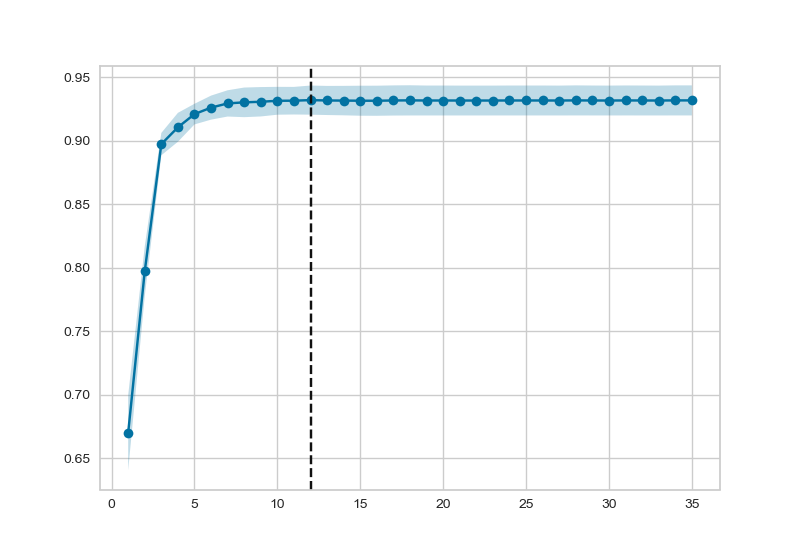

The optimal number of features is 12


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X[featuresFull], y, test_size=.2)

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

selector = RFECV(RandomForestRegressor(n_estimators = 10, max_depth = 3, random_state=42, n_jobs=-1), cv=cv, scoring='explained_variance', verbose = 1, n_jobs=-1)
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]

<IPython.core.display.Javascript object>


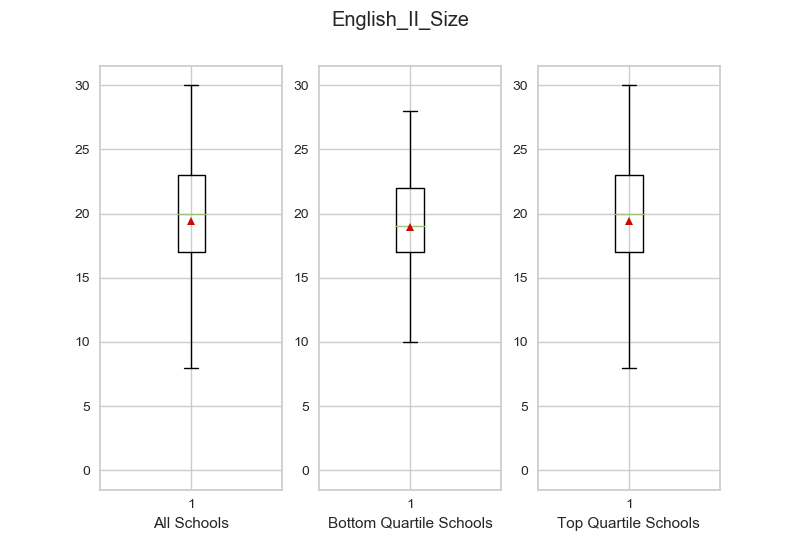

<IPython.core.display.Javascript object>


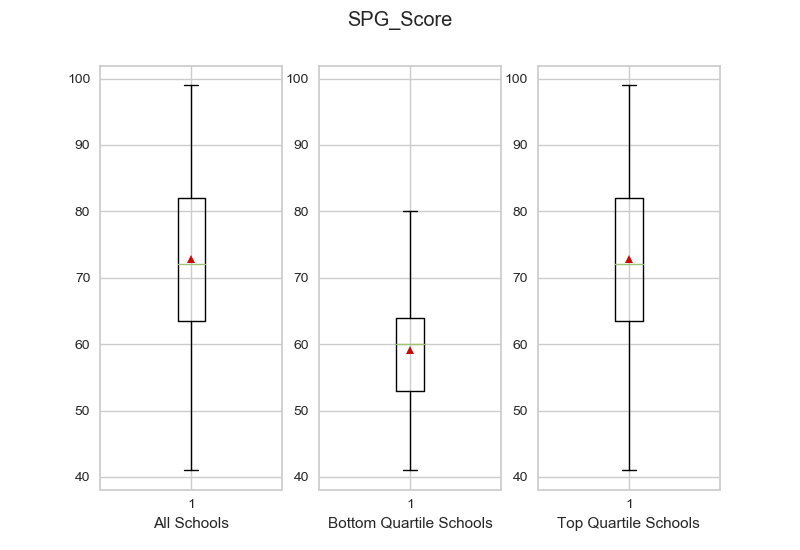

<IPython.core.display.Javascript object>


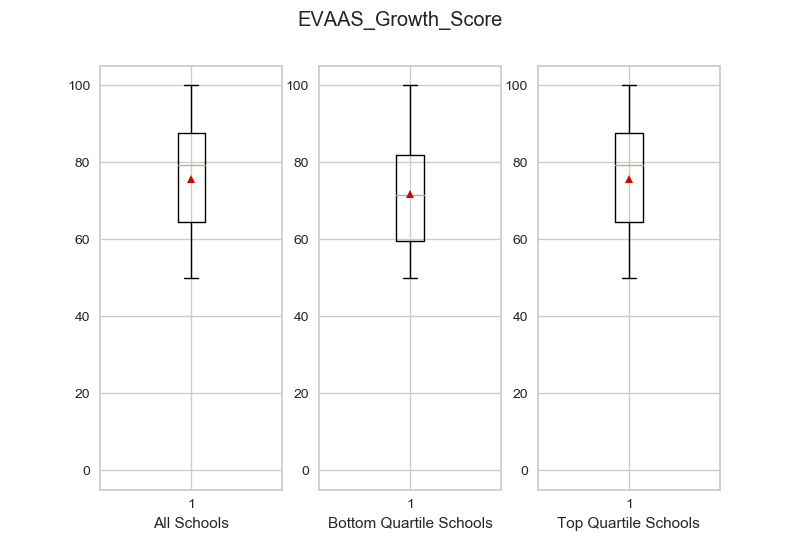

<IPython.core.display.Javascript object>


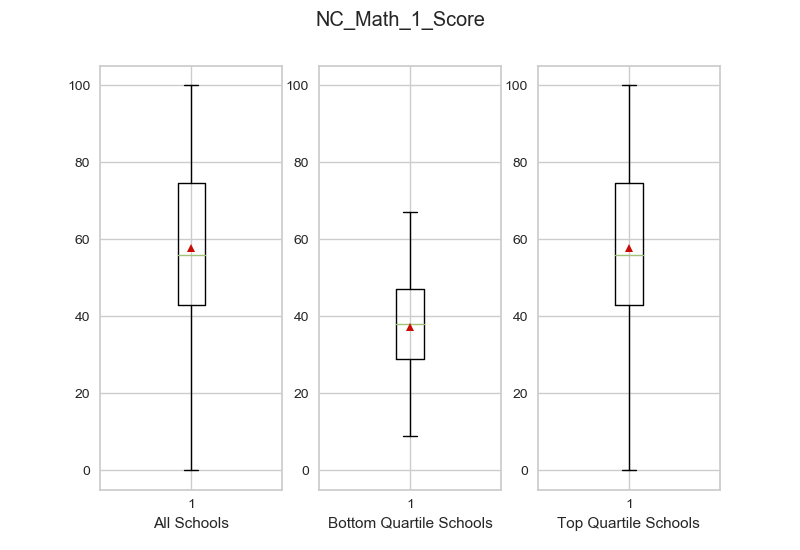

<IPython.core.display.Javascript object>


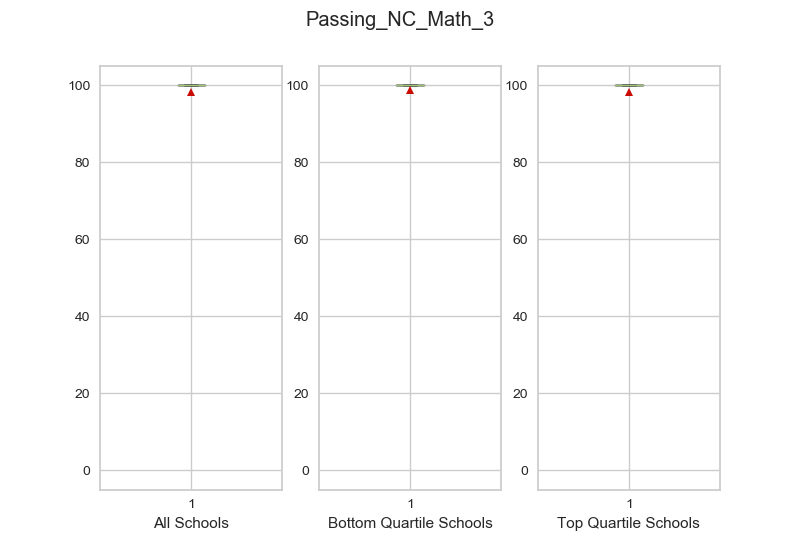

<IPython.core.display.Javascript object>


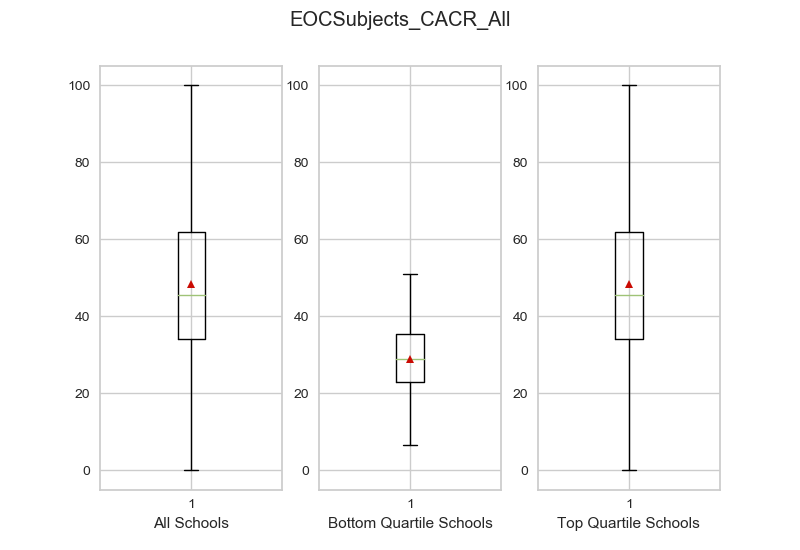

<IPython.core.display.Javascript object>


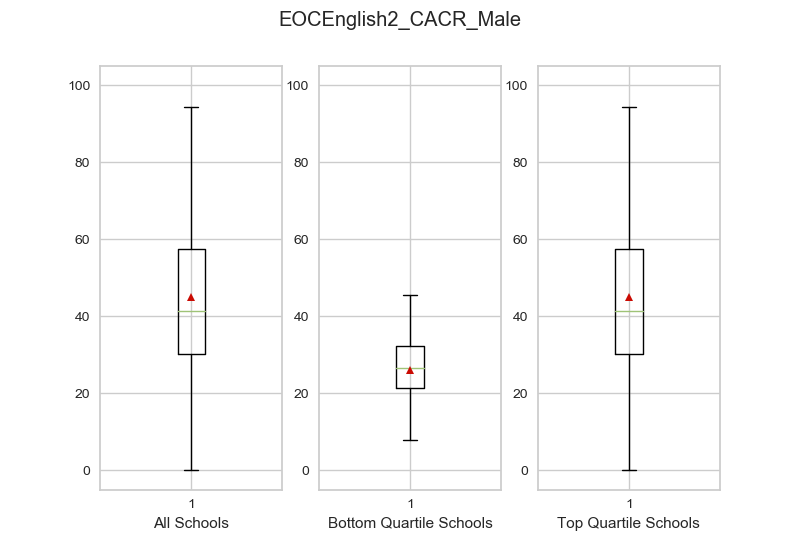

<IPython.core.display.Javascript object>


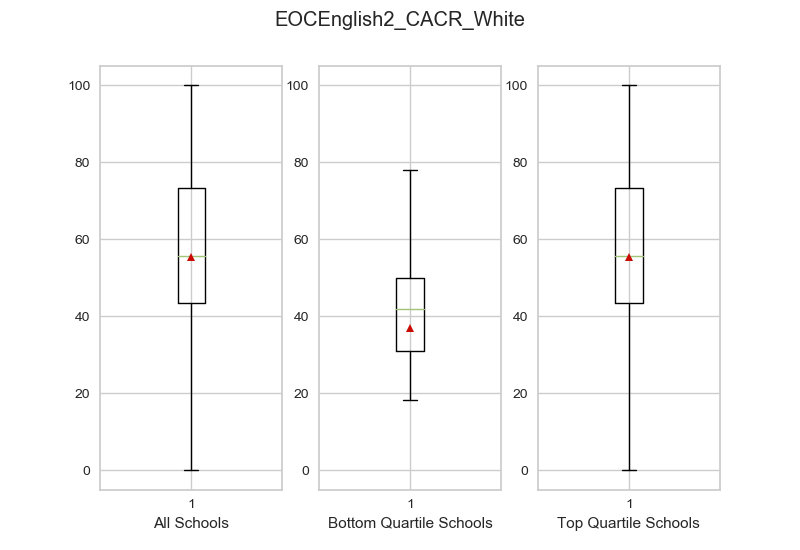

<IPython.core.display.Javascript object>


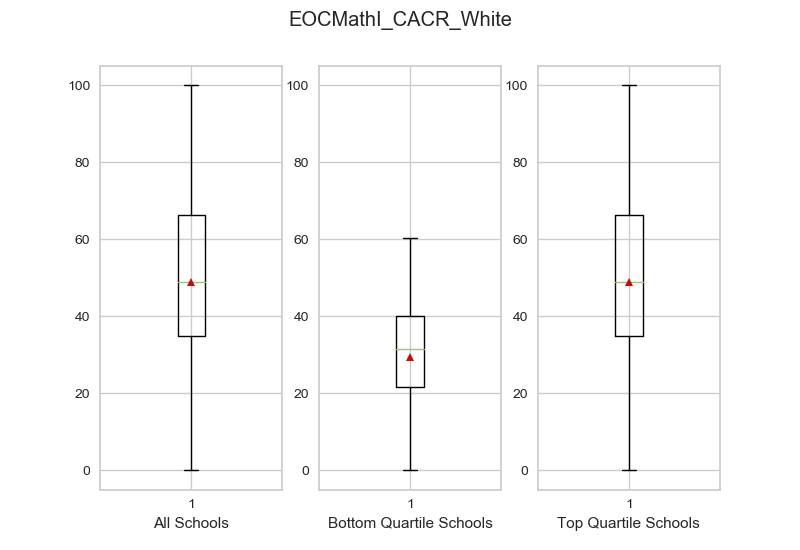

<IPython.core.display.Javascript object>


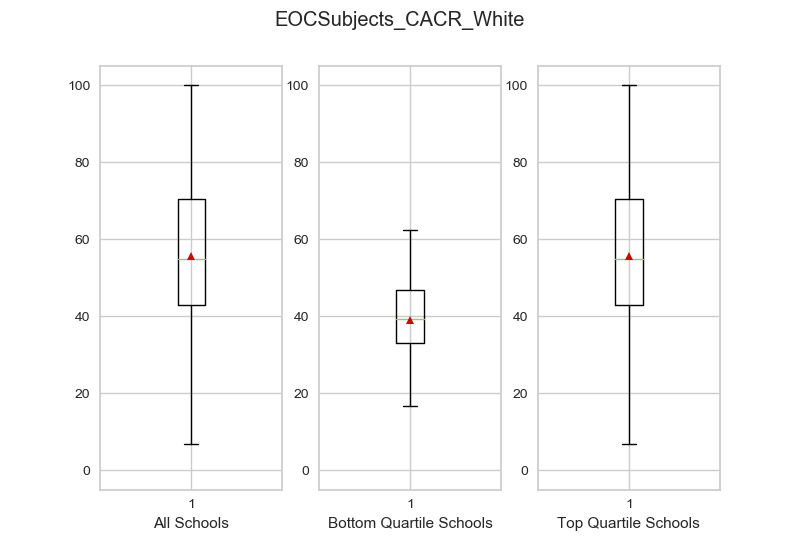

<IPython.core.display.Javascript object>


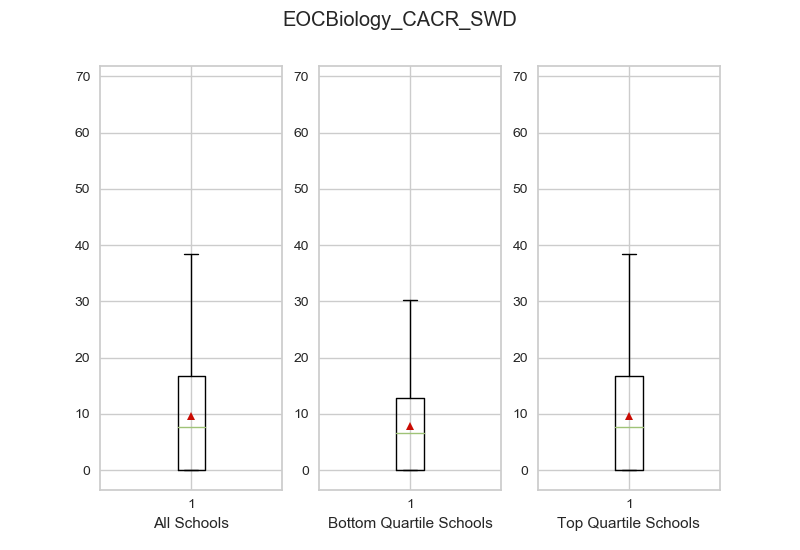

<IPython.core.display.Javascript object>


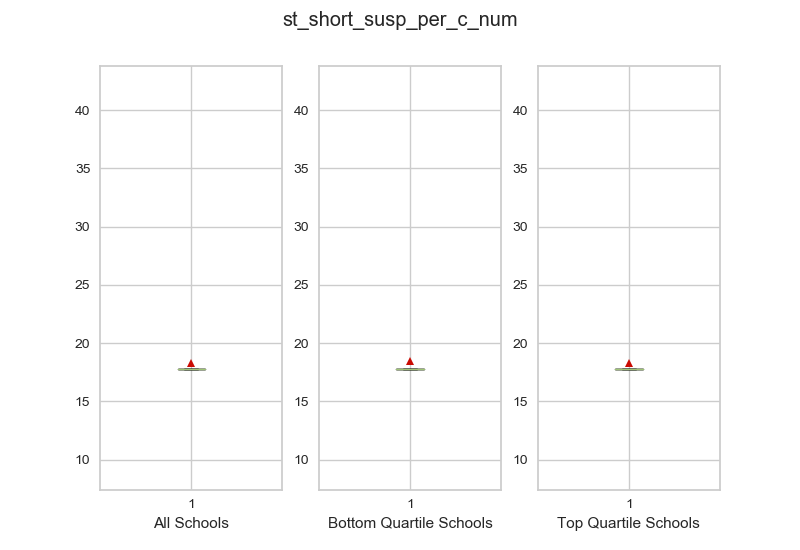

<IPython.core.display.Javascript object>


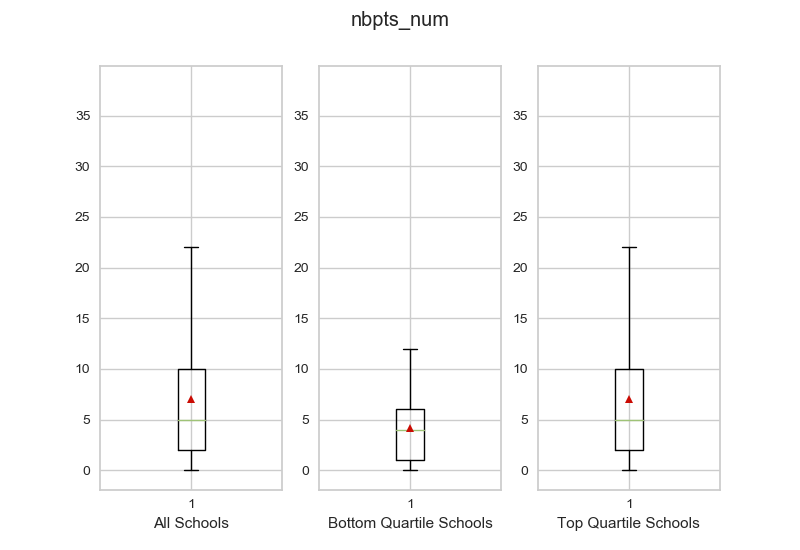

<IPython.core.display.Javascript object>


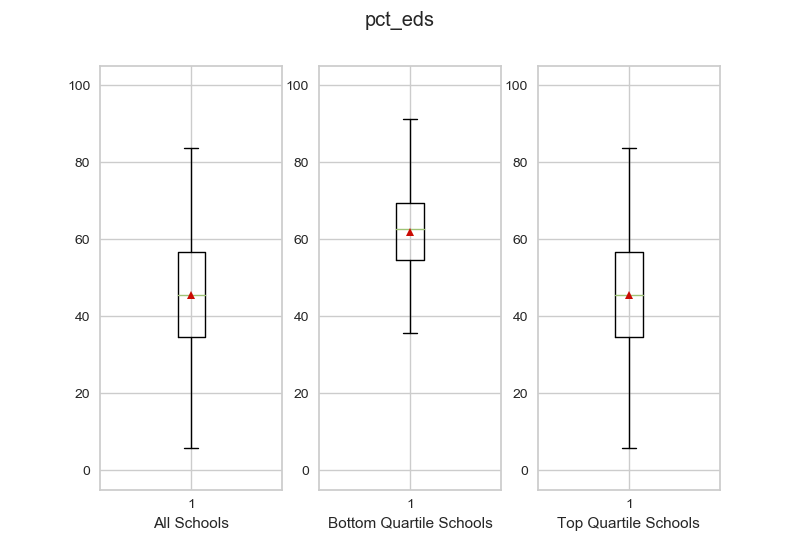

In [27]:
featCols = ['English_II_Size', 'SPG_Score', 'EVAAS_Growth_Score', 'NC_Math_1_Score', 
            'Passing_NC_Math_3', 'EOCSubjects_CACR_All', 'EOCEnglish2_CACR_Male',
            'EOCEnglish2_CACR_White', 'EOCMathI_CACR_White', 'EOCSubjects_CACR_White',
            'EOCBiology_CACR_SWD', 'st_short_susp_per_c_num', 'nbpts_num', 'pct_eds']

for feat in featCols:
    fig = plt.figure()
    fig.suptitle(feat)

    ax = fig.add_subplot(131)
    plt.boxplot(dfDropped[feat], showmeans=True)
    ax.set_xlabel('All Schools')

    ax = fig.add_subplot(132, sharey=ax)
    btmQ = dfDropped[dfDropped['Q25'] == 1]
    plt.boxplot(btmQ[feat], showmeans=True)
    ax.set_xlabel('Bottom Quartile Schools')

    ax = fig.add_subplot(133, sharey=ax)
    topQ = dfDropped[dfDropped['Q100'] == 1]
    plt.boxplot(topQ[feat], showmeans=True)
    ax.set_xlabel('Top Quartile Schools')

**English_II_Size**
The mean for all schools is 19.1. The mean for all schools in the bottom quartile is smaller since it's around 17. The box plot for all schools in the bottom quartile is lower than the box plot for all schools and top quartile schools as expected. 

**SPG_Score**
The mean School Performance Grade for all schools is 72.7. The mean for all schools in the bottom quartile is much lower than the mean for all schools with a score of 60. Surprisingly the mean for all schools in the top quartile is around the same as the mean across all schools. The box plot for all schools looks almost identical to the box plot for the top quartile. 

**Before I continue, am I on the right track on how I'm interpreting this?**

**EVAAS_Growth_Score**

**NC_Math_1_Score**

**Passing_NC_Math_3**

**EOCSubjects_CACR_All**

**EOCEnglish2_CACR_Male**

**EOCEnglish2_CACR_White**

**EOCMath1_CACR_White**

**EOCSubjects_CACR_White**

**EOCBiology_CACR_SWD**

**st_short_susp_per_c_num**

**nbpts_num**

**pct_eds**

In [28]:
breaks = np.asarray(np.percentile(dfDropped['ACT_Score'], [25,50,75,100]))
dfDropped['ACT_Score_Quartiles'] = (dfDropped['ACT_Score'].values > breaks[..., np.newaxis]).sum(0)

<IPython.core.display.Javascript object>


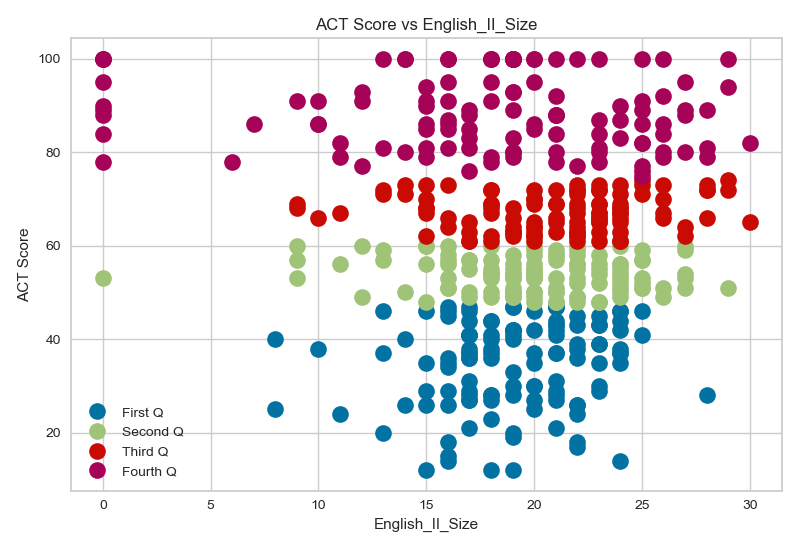

<IPython.core.display.Javascript object>


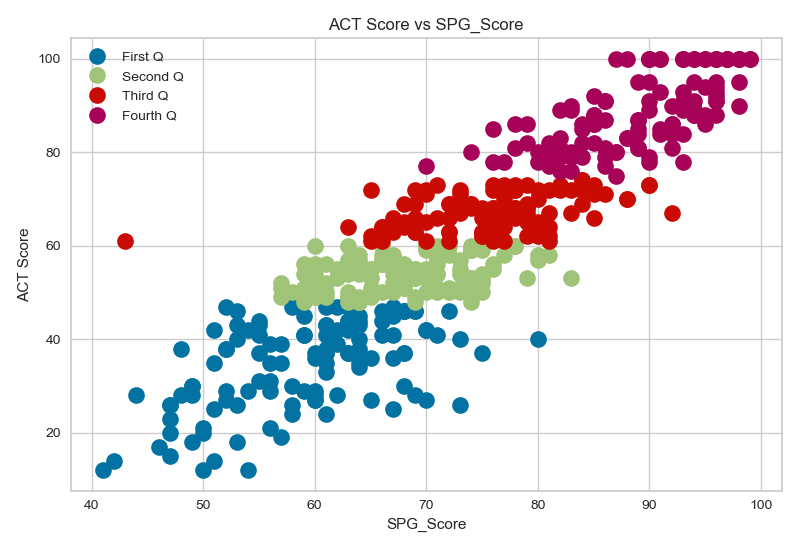

<IPython.core.display.Javascript object>


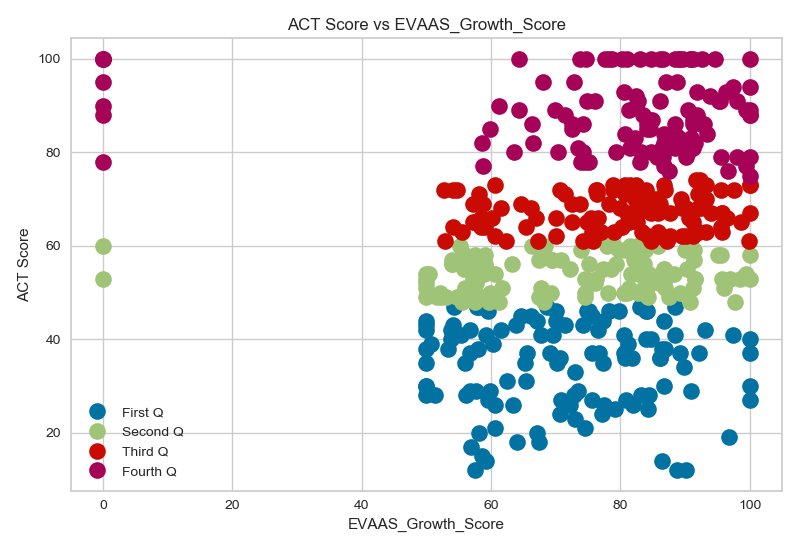

<IPython.core.display.Javascript object>


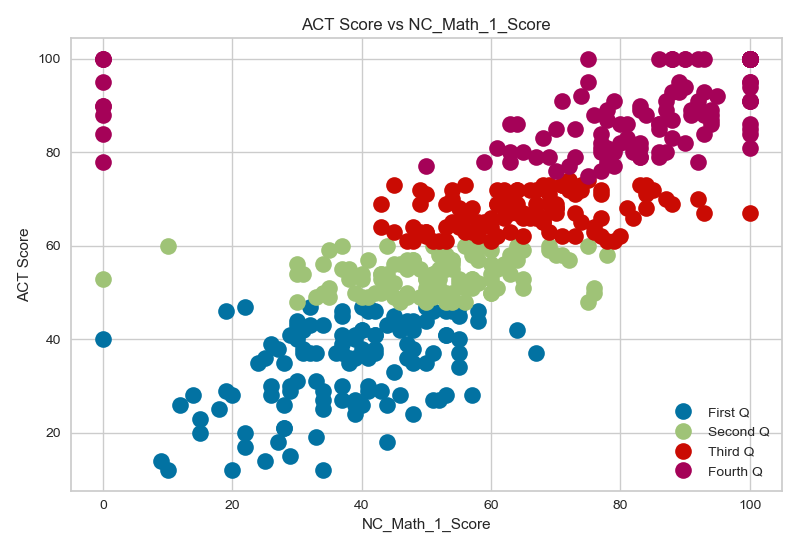

<IPython.core.display.Javascript object>


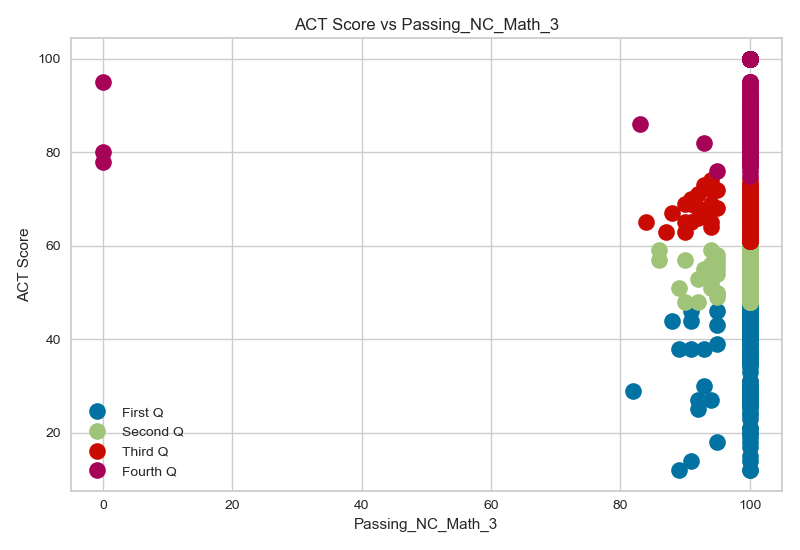

<IPython.core.display.Javascript object>


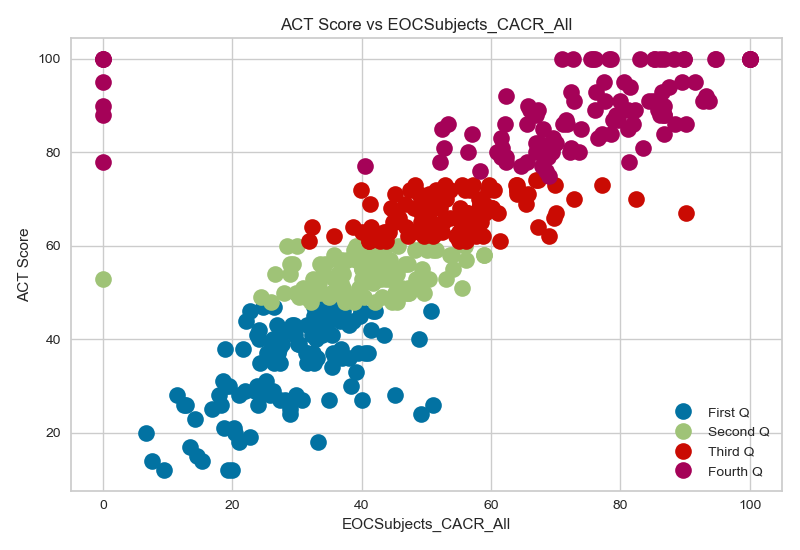

<IPython.core.display.Javascript object>


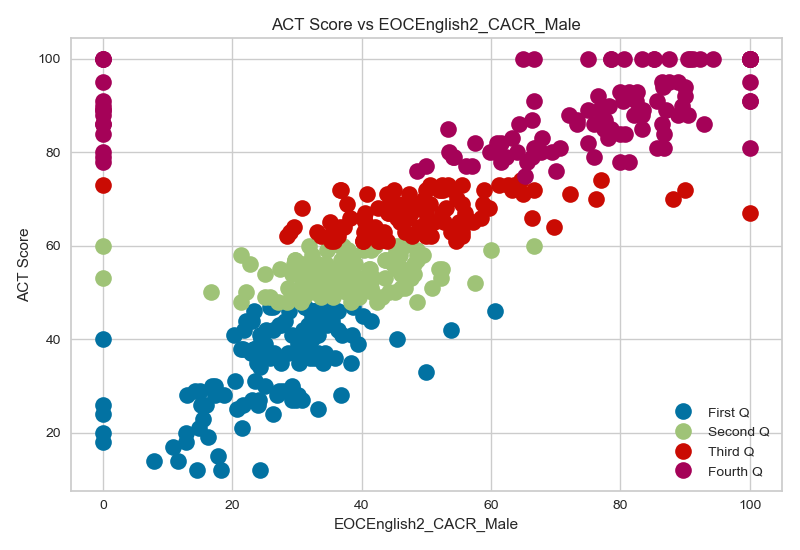

<IPython.core.display.Javascript object>


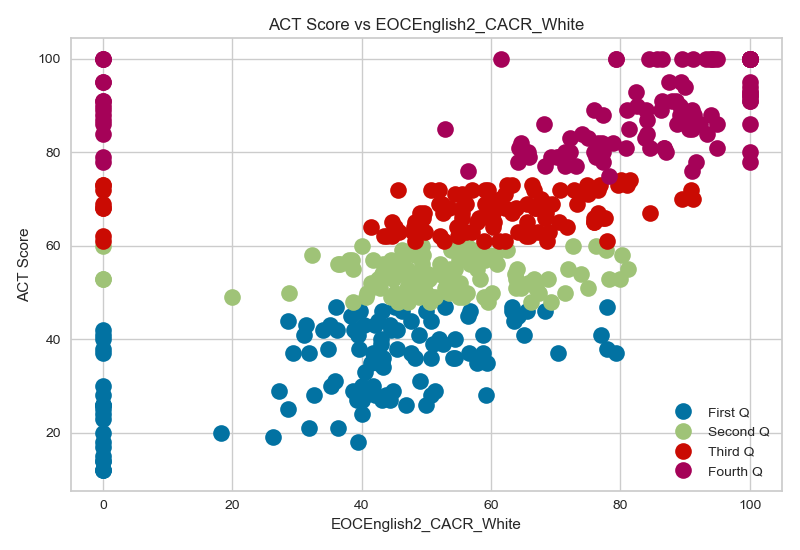

<IPython.core.display.Javascript object>


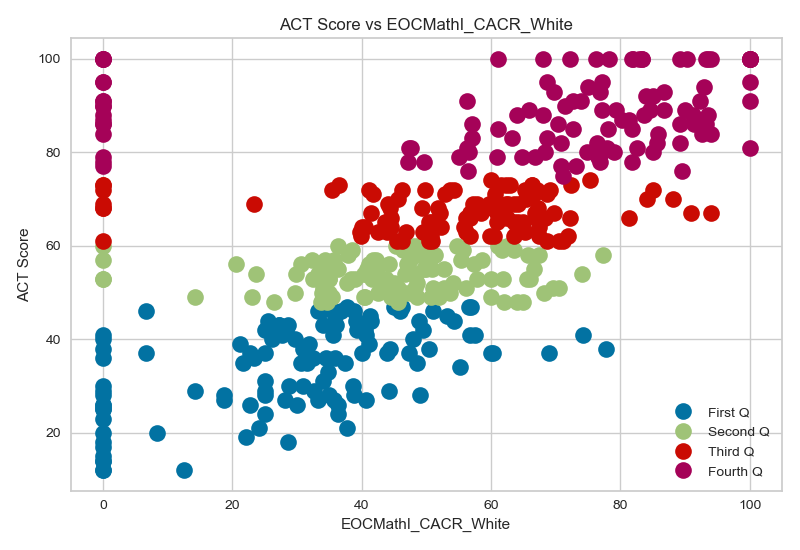

<IPython.core.display.Javascript object>


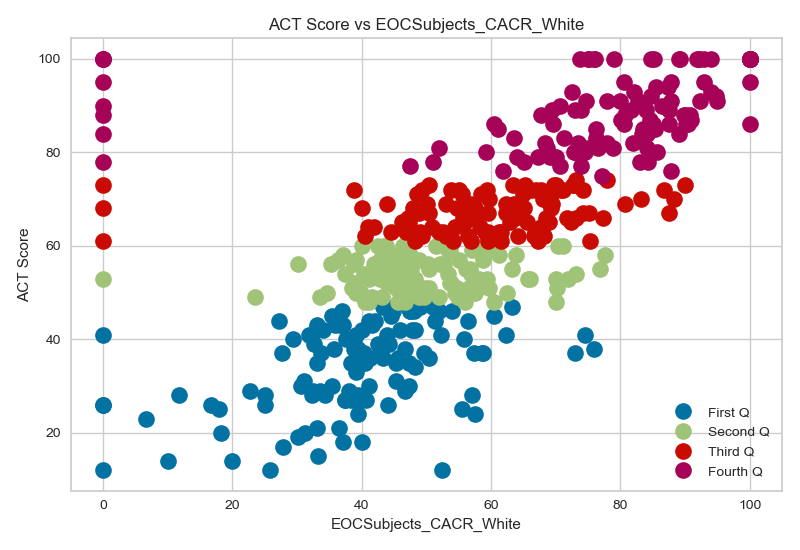

<IPython.core.display.Javascript object>


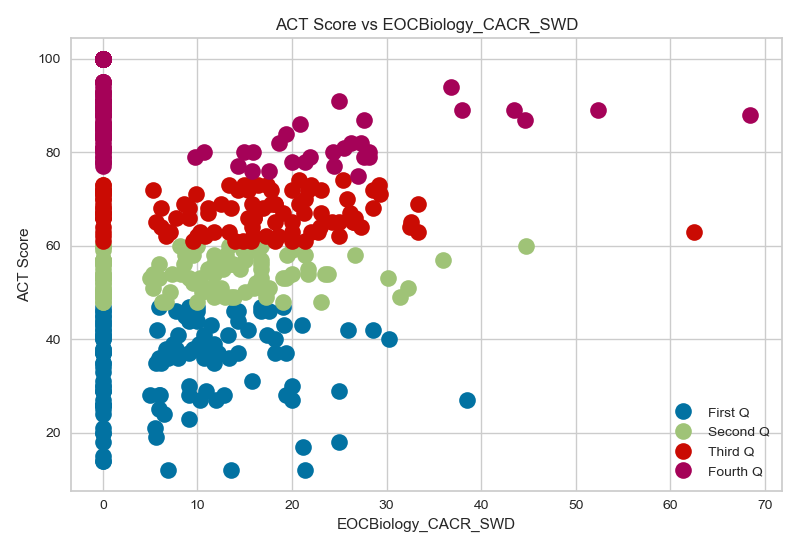

<IPython.core.display.Javascript object>


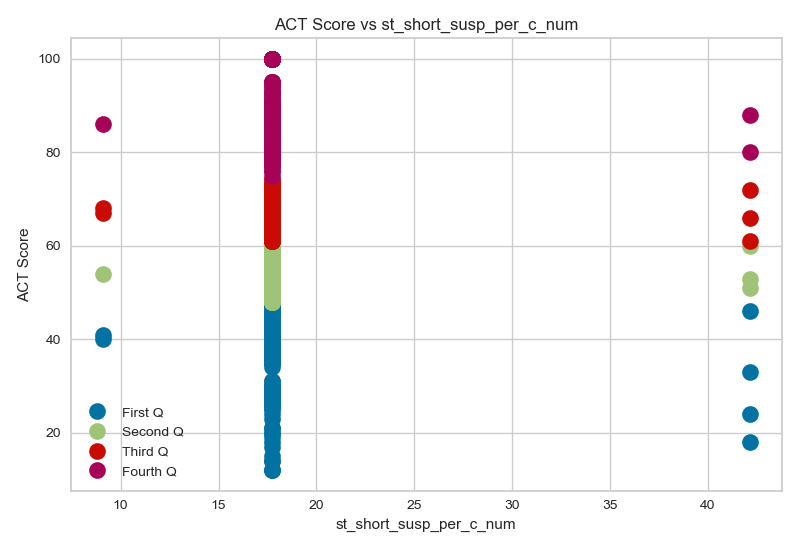

<IPython.core.display.Javascript object>


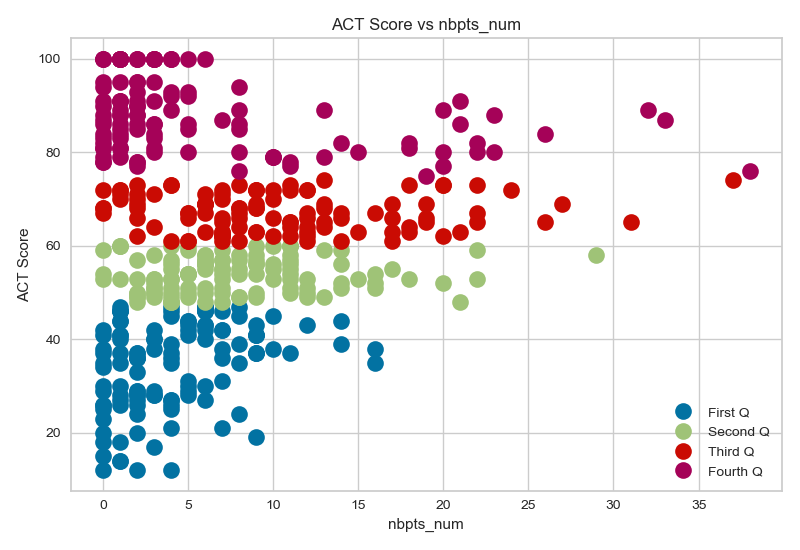

<IPython.core.display.Javascript object>


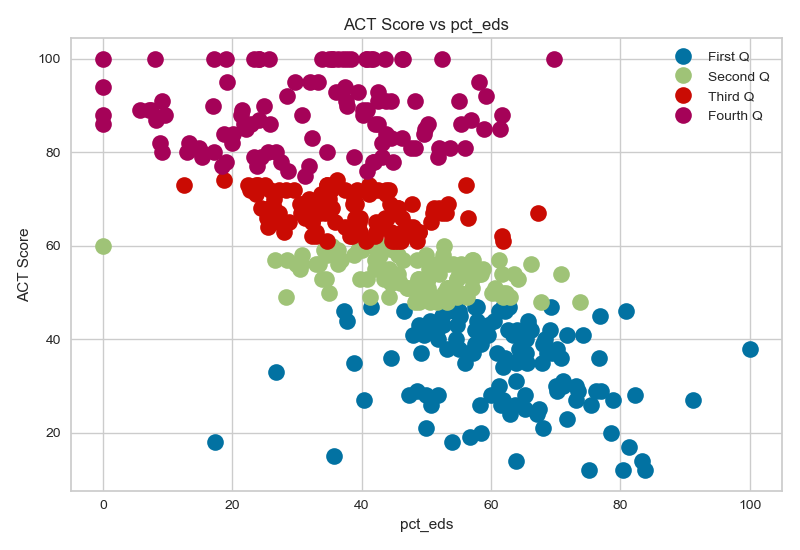

In [29]:
quartile = {0: "First Q", 1: "Second Q", 2: "Third Q", 3: "Fourth Q"}

# scatter plot code from: https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
groups = dfDropped.groupby('ACT_Score_Quartiles')

for feat in featCols:
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(getattr(group, feat), group.ACT_Score, marker='o', 
                    linestyle='', ms=12, label=quartile[name])
    ax.legend()
    ax.set(title='ACT Score vs ' + feat, 
               xlabel=feat,
               ylabel='ACT Score')

    plt.show()
    plt.tight_layout()

## DESCRIBE FINAL THE MAIN DATA SETS HERE: Feature Columns, Quarts Top/Bottom,  

<a href="#top">Back to Top</a> 
## Modeling and Evaluation (50 points total)

<span style="color: blue">Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by: 

<ul style = "color: blue">
<li>Train and Adjust Parameters</li>
<li>Evaluate and Compare</li>
<li>Visualize Results</li>
<li>Summarize the Ramifications</li>

For the analysis process, we employed four clustering methods on the two data sets noted above. An overview of each method is outlined here, and the specific parameters used are summarized below. 

#### K Means
K-Means is a clustering technique that attempts to find a find a user-defined number of clusters, K. The methodology used to create clusters is prototype-based and partitional, where the specific object being clustered is more similar (also closer) to the object that defines the cluster and where objects are simply divided into non-overlapping subsets, or clusters. 

A more technical way of defining K-Means is that the algorithm is trying to separate objects into n groups of equal variances, while minimizing the within-cluster sum-of-squares. It is an iterative process, where the results is usually a local, optimal value but not necessarily a global optimum. The distance measurements available include Euclidean, Manhattan, and cosine; the centroid measurements are commonly median or mean. 

#### Mini-Batch K-Means
Mini-Batch K-Means clustering is a variant of K-Means but creates subsets of data that have been randomly sampled during each training iteration. This process reduces the time needed for computation while still optimizing the same K-Means function. It tends to converge faster, but the results quality in practice may be slightly reduced than in the full K-Means algorithm. 

#### DBSCAN
DBSCAN is a density-based algorithm that clusters dense regions of objects (core points and border points) surrounded by low density regions. The number of clusters is determined by the algorithm automatically. The lower-density regions are considered noise points and omitted from the results, which produces partial clusters that do not contain all data points. Overall, DBSCAN clusters can be any shape. Important DBSCAN definitions and parameters include:
- Core points: the interior points of a density-based cluster, where a point is defined as “core” if the number of points within a given neighborhood is within a specified distance
- Border points: a point that falls within the neighborhood of a core point
- Noise points: a point that is not a core point or border point
- Eps: a user-defined distance parameter, maximum distance between two samples for them to be considered as in the same neighborhood
- MinPts: a user-defined parameter threshold, number of samples in a neighborhood for a point to be considered as a core point, including the point itself

#### Agglomerative Hierarchical Clustering
Agglomerative Hierarchical Clustering is a collection of similarly related techniques that produce a hierarchical cluster (a set of nested clusters that are organized as a tree). The algorithm starts with each data point as a single cluster and then repeatedly merges the two closest until a single, all-encompassing cluster remains. 

### NEED TO WRITE THE PARAMETERS OF AHC HERE - Ward, Min/Max, etc.

#### Summary/Snapshot of Clustering Methods

| Method name                  | Parameters                                 | Scalability                                                 | Best Use Case                                                                   | Geometry/Measurement Metric                       |
|------------------------------|--------------------------------------------|-------------------------------------------------------------|---------------------------------------------------------------------------|----------------------------------------------|
| K-Means                      | number of clusters                         | Very large n_samples, medium n_clusters with MiniBatch code | General-purpose, even cluster size, flat geometry, not too many clusters  | Distances between points                     |
| DBSCAN                       | neighborhood size                          | Very large n_samples, medium n_clusters                     | Non-flat geometry, uneven cluster sizes                                   | Distances between nearest points             |
| Agglomerative clustering     | number of clusters, linkage type, distance | Large n_samples and n_clusters                              | Many clusters, possibly connectivity constraints, non Euclidean distances | Any pairwise distance                        |
| Ward hierarchical clustering | number of clusters                         | Large n_samples and n_clusters                              | Many clusters, possibly connectivity constraints                          | Distances between points                     |


<a href="#top">Back to Top</a> 
<a id="Model1"></a>
## TRAIN AND ADJUST PARAMETERS (10 points)

### Cluster Tuning Parameters

|     Parameters     |                     Description                    |          Range          |
|:------------------:|:--------------------------------------------------:|:-----------------------:|
| Number of Clusters | How many clusters to form                          |                  2 - 10 |
| Minimum Samples    | Minimum number of instances to become a cluster    |                 10 - 20 |
| Epsilon            | Maximum distance from cluster for instance to stay |                 15 - 25 |
| Link               | Distance to use for instances to stay in cluster   | Ward, Complete, Average |

### All Quartiles

In [30]:
# create cross validation variable
cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

# training data
X = dfDropped[featCols]

# target variable
y = dfDropped['ACT_Score_Quartiles']

# Classifier
cls = RandomForestClassifier(random_state = 42)

# Results Dictionary
bestResults = {}

#### Cluster 1

In [31]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = KMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreRF(X, y, cLabels)
      
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['kmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Result: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.3644676725879654
Best Accuracy Score: 
	 K Size: 2 
	 Result: 0.6956521739130435


#### Cluster 2

In [32]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = MiniBatchKMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreRF(X, y, cLabels)

    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['batchkmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Accuracy: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.36481868690643277
Best Accuracy Score: 
	 K Size: 9 
	 Accuracy: 0.6815217391304348


#### Cluster 3

In [33]:
bestAcc = 0
bestSil = -2

for minS in np.arange(10, 20):
    for eps in np.arange(15, 25):
        # Instantiate the clustering model
        model = DBSCAN(eps = eps, min_samples=minS, n_jobs=-1)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFMinS = minS
        bestRFEps = eps
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilMinS = minS
        bestSilEps = eps
        bestSilLabels = cLabels
        
bestResults['dbscan'] = bestAcc

print("Best Silhouette Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Silhouette Score: {}".format(bestSilMinS, bestSilEps, bestSil))
print("Best Accuracy Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Accuracy: {}".format(bestRFMinS, bestRFEps, bestAcc))

Best Silhouette Score: 
	 Min Samples: 10 
	 Eps: 24 
	 Silhouette Score: 0.22018844966327106
Best Accuracy Score: 
	 Min Samples: 10 
	 Eps: 24 
	 Accuracy: 0.658695652173913


#### Cluster 4

In [34]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    for link in ['ward', 'complete', 'average']:
        # Instantiate the clustering model
        model = AgglomerativeClustering(n_clusters = kSize, linkage = link)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
        if result['mean'] > bestAcc:
            bestAcc = result['mean']
            bestRFkSize = kSize
            bestRFLink = link
            bestRFLabels = cLabels
        
        if result['sil'] > bestSil:
            bestSil = result['sil']
            bestSilkSize = kSize
            bestSilLink = link
            bestSilLabels = cLabels
        
bestResults['agg'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Link: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSilLink, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Link: {} \n\t Accuracy: {}".format(bestRFkSize, bestRFLink, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Link: average 
	 Silhouette Score: 0.5002561413478372
Best Accuracy Score: 
	 K Size: 9 
	 Link: ward 
	 Accuracy: 0.6554347826086957


### Top & Bottom Quartiles Only

In [35]:
dfExtremes = dfDropped[(dfDropped['ACT_Score_Quartiles'] == 0) | (dfDropped['ACT_Score_Quartiles'] == 3)]

X = dfExtremes[featCols]

y = dfExtremes['ACT_Score_Quartiles']

#### Cluster 5

In [36]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = KMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreExtremeRF(X, y, cLabels)
      
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['extreme_kmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Result: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.5017249673944034
Best Accuracy Score: 
	 K Size: 2 
	 Result: 0.9851063829787234


#### Cluster 6

In [44]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    # Instantiate the clustering model
    model = MiniBatchKMeans(n_clusters = kSize, random_state = 42)
    model.fit(X)
    cLabels = model.labels_
    
    X = np.column_stack((X, pd.get_dummies(cLabels)))
    result = scoreExtremeRF(X, y, cLabels)

    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFkSize = kSize
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilkSize = kSize
        bestSilLabels = cLabels
        
bestResults['extreme_batchkmeans'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Accuracy: {}".format(bestRFkSize, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Silhouette Score: 0.5014952813546882
Best Accuracy Score: 
	 K Size: 3 
	 Accuracy: 0.9872340425531915


#### Cluster 7

In [38]:
bestAcc = 0
bestSil = -2

for minS in np.arange(10, 20):
    for eps in np.arange(15, 25):
        # Instantiate the clustering model
        model = DBSCAN(eps = eps, min_samples=minS, n_jobs=-1)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreExtremeRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
    if result['mean'] > bestAcc:
        bestAcc = result['mean']
        bestRFMinS = minS
        bestRFEps = eps
        bestRFLabels = cLabels
        
    if result['sil'] > bestSil:
        bestSil = result['sil']
        bestSilMinS = minS
        bestSilEps = eps
        bestSilLabels = cLabels
        
bestResults['extreme_dbscan'] = bestAcc

print("Best Silhouette Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Silhouette Score: {}".format(bestSilMinS, bestSilEps, bestSil))
print("Best Accuracy Score: \n\t Min Samples: {} \n\t Eps: {} \n\t Accuracy: {}".format(bestRFMinS, bestRFEps, bestAcc))

Best Silhouette Score: 
	 Min Samples: 18 
	 Eps: 24 
	 Silhouette Score: 0.0814370539597228
Best Accuracy Score: 
	 Min Samples: 10 
	 Eps: 24 
	 Accuracy: 0.9829787234042554


#### Cluster 8

In [46]:
bestAcc = 0
bestSil = -2

for kSize in np.arange(2, 10):
    for link in ['ward', 'complete', 'average']:
        # Instantiate the clustering model
        model = AgglomerativeClustering(n_clusters = kSize, linkage = link)
        model.fit(X)
        cLabels = model.labels_

        X = np.column_stack((X, pd.get_dummies(cLabels)))
        result = scoreExtremeRF(X, y, cLabels)

        #print("Eps: {} \t Min Samples: {} \t Result: {}".format(eps, minS, result['mean']))
        
        if result['mean'] > bestAcc:
            bestAcc = result['mean']
            bestRFkSize = kSize
            bestRFLink = link
            bestRFLabels = cLabels
        
        if result['sil'] > bestSil:
            bestSil = result['sil']
            bestSilkSize = kSize
            bestSilLink = link
            bestSilLabels = cLabels
        
bestResults['extreme_agg'] = bestAcc

print("Best Silhouette Score: \n\t K Size: {} \n\t Link: {} \n\t Silhouette Score: {}".format(bestSilkSize, bestSilLink, bestSil))
print("Best Accuracy Score: \n\t K Size: {} \n\t Link: {} \n\t Accuracy: {}".format(bestRFkSize, bestRFLink, bestAcc))

Best Silhouette Score: 
	 K Size: 2 
	 Link: ward 
	 Silhouette Score: 0.4954828095343213
Best Accuracy Score: 
	 K Size: 2 
	 Link: ward 
	 Accuracy: 0.9872340425531915


In [47]:
pprint(bestResults)
print("Best clustering method: {}".format(max(bestResults, key=bestResults.get)))

{'agg': 0.6554347826086957,
 'batchkmeans': 0.6815217391304348,
 'dbscan': 0.658695652173913,
 'extreme_agg': 0.9872340425531915,
 'extreme_batchkmeans': 0.9872340425531915,
 'extreme_dbscan': 0.9829787234042554,
 'extreme_kmeans': 0.9851063829787234,
 'kmeans': 0.6956521739130435}
Best clustering method: extreme_batchkmeans


In [48]:
print("Based on the accuracy of each model '{}' is the best clustering method for this data.".format(max(bestResults, key=bestResults.get)))

Based on the accuracy of each model 'extreme_batchkmeans' is the best clustering method for this data.


In [49]:
model = MiniBatchKMeans(n_clusters = 2, random_state = 42)
model.fit(dfExtremes[featCols])
cLabels = model.labels_

In [50]:
# Data
X_Dropped = dfDropped[featCols]

# Target
y_Dropped = dfDropped['ACT_Score_Quartiles']

# Training and testing data
X_train_Dropped, X_test_Dropped, y_train_Dropped, y_test_Dropped = train_test_split(X_Dropped, y_Dropped, random_state=42, test_size=.2)

# Data
X_extreme = dfExtremes[featCols]

# target
y_extreme = dfExtremes['ACT_Score_Quartiles']

# training and testing data
X_train_extreme, X_test_extreme, y_train_extreme, y_test_extreme = train_test_split(X_extreme, y_extreme, random_state=42, test_size=.2)

# Add clustering labels into data
dfCluster = np.column_stack((X_extreme, pd.get_dummies(cLabels)))

X_cluster = dfCluster

y_cluster = dfExtremes['ACT_Score_Quartiles']

X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, y_cluster, random_state=42, test_size=.2)

### RandomForest Tuning Parameters

|    Parameters    |                     Description                    |    Range   |
|:----------------:|:--------------------------------------------------:|:----------:|
| Max Depth        | Max levels down from root                          |   40 - 140 |
| Min Sample Split | Min samples before a split of samples should occur |     2 - 10 |
| Min Sample Leaf  | Min samples allowed to be considered a leaf        |     1 - 10 |
| Estimators       | Number of trees to generate                        | 200 - 2000 |

### RF Model Parameter Tuning
For each model, four features are tuned to determine the best results. The blue line identifies how well the model performs on the training data. A score closer to 1 is best. The green curve shows how the model performs on the test data. Again a score closer to 1 is best. By looking at these curves we can identify the optimum value for the tuning parameter and when the model starts to overfit the data. An example of overfitting would be where the blue curve starts to track upward and the green curve starts to track downward. 

### RF Model 1
#### Estimators

<IPython.core.display.Javascript object>


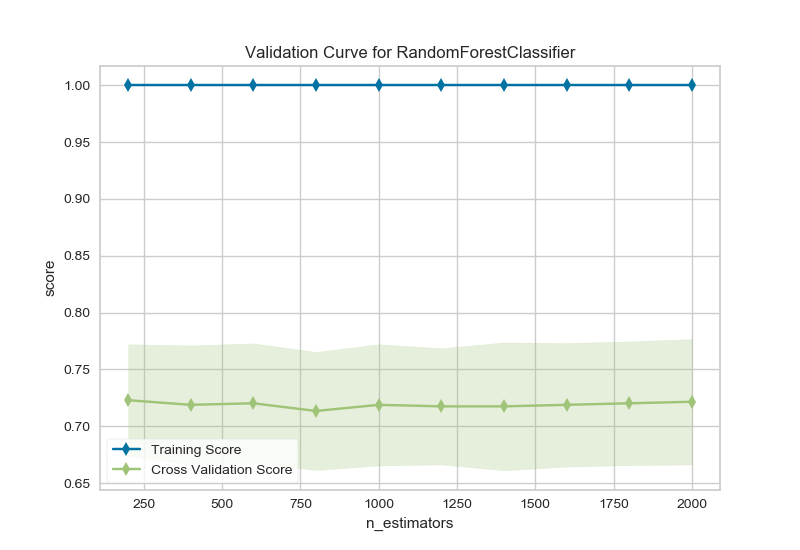

In [38]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    cv = cv, scoring = 'accuracy', n_jobs = -1
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

#### Max Depth

<IPython.core.display.Javascript object>


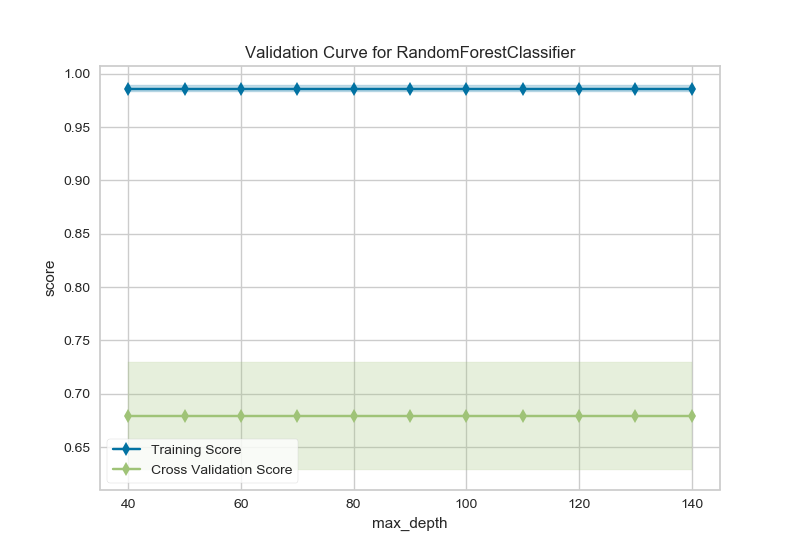

In [220]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

#### Minimum Sample Split

<IPython.core.display.Javascript object>


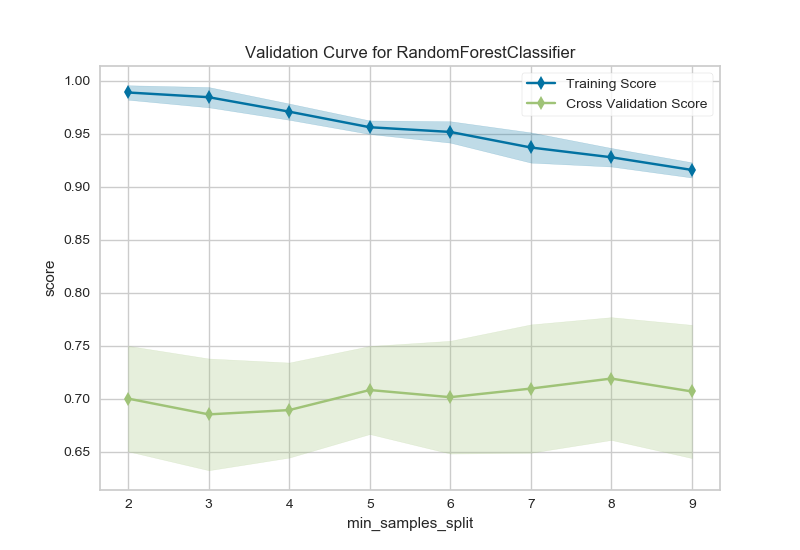

In [39]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

#### Minimum Samples per Leaf

<IPython.core.display.Javascript object>


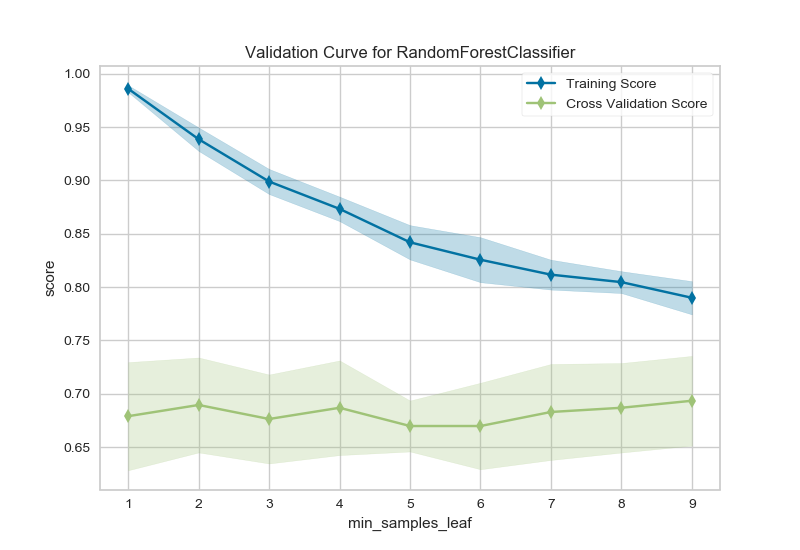

In [224]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_Dropped, y_train_Dropped)
viz.poof()

### RF Model 2
#### Estimators

<IPython.core.display.Javascript object>


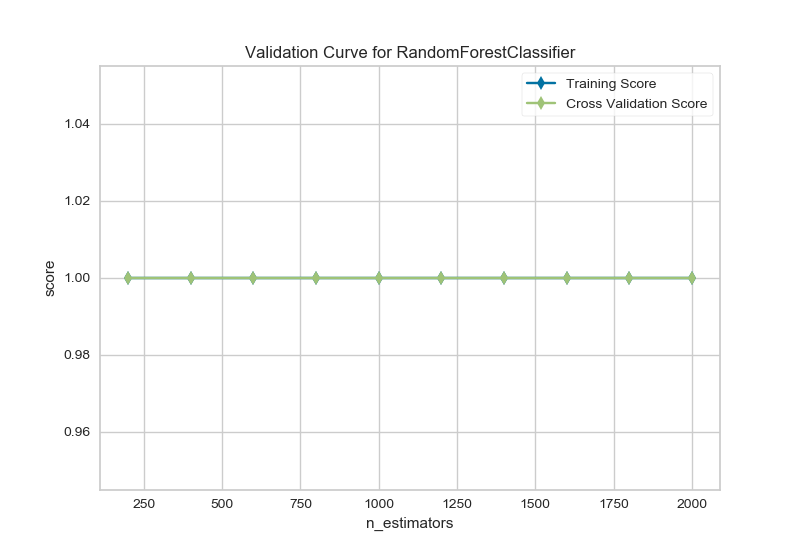

In [45]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    cv = cv, scoring = 'accuracy', n_jobs = -1
)

viz.fit(X_train_extreme, y_train_extreme)
viz.poof()

#### Max Depth

<IPython.core.display.Javascript object>


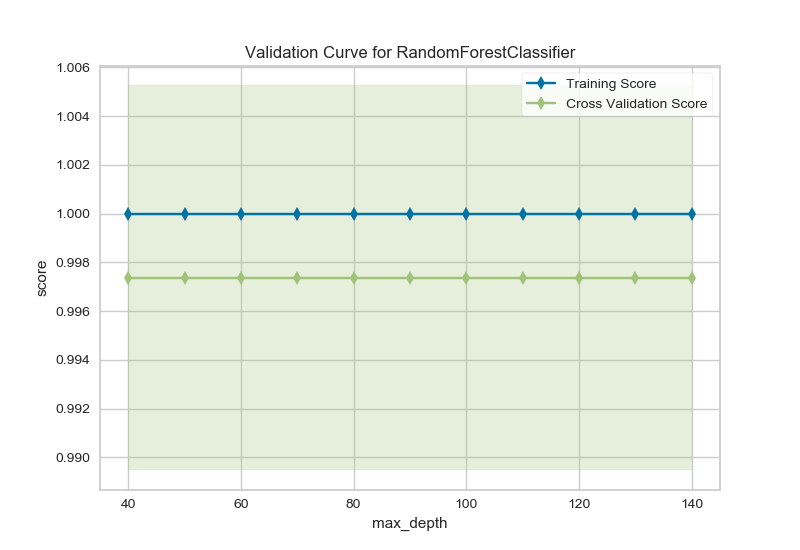

In [46]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_extreme, y_train_extreme)
viz.poof()

#### Mininum Simples for Split

<IPython.core.display.Javascript object>


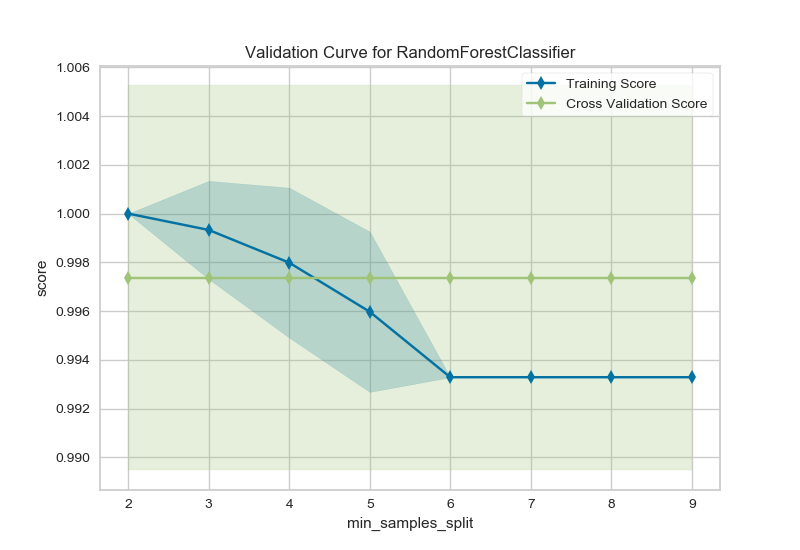

In [47]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_extreme, y_train_extreme)
viz.poof()

#### Minumum Samples per Leaf

<IPython.core.display.Javascript object>


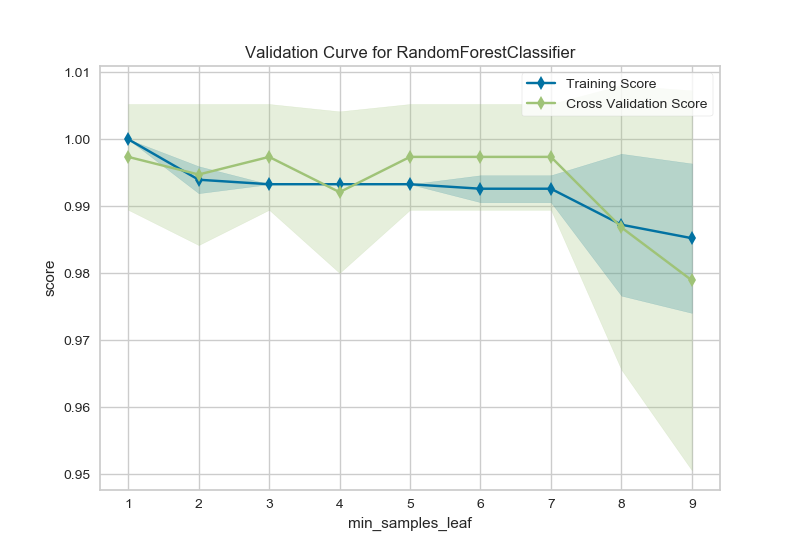

In [51]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_extreme, y_train_extreme)
viz.poof()

### RF Model 3
#### Estimators

<IPython.core.display.Javascript object>


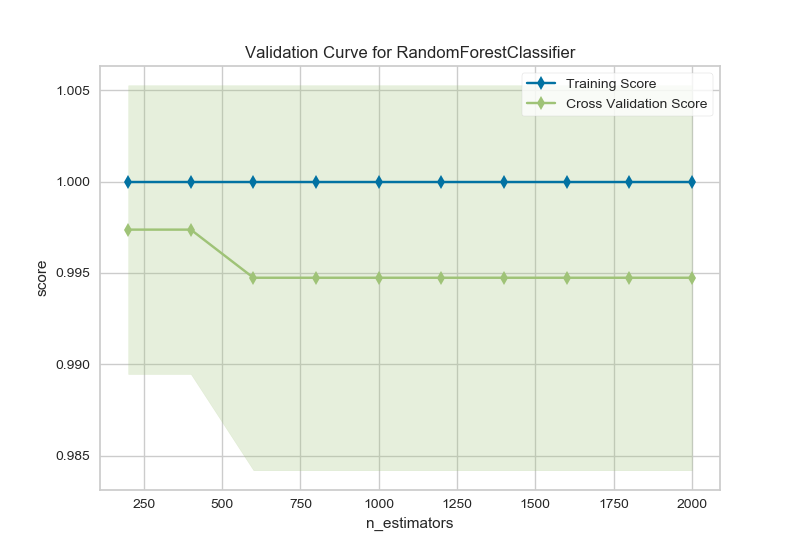

In [52]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'n_estimators',
    param_range = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    cv = cv, scoring = 'accuracy', n_jobs = -1
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

#### Max Depth

<IPython.core.display.Javascript object>


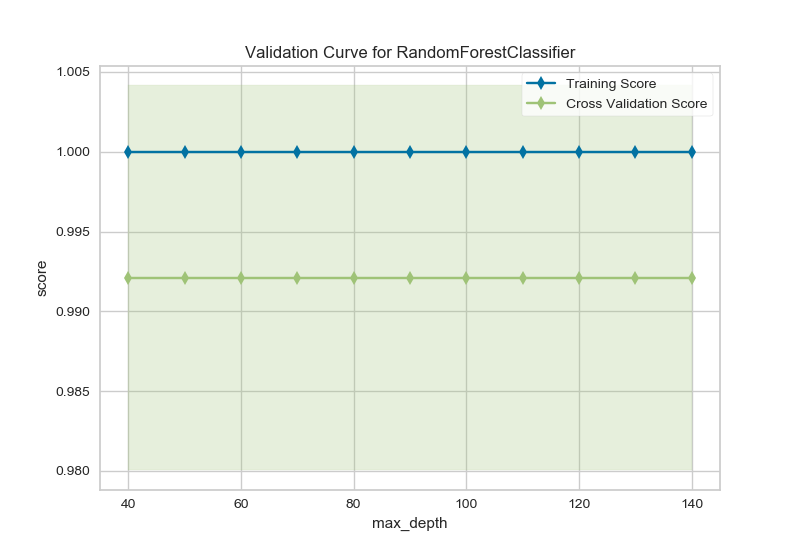

In [53]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'max_depth',
    param_range = [int(x) for x in np.linspace(40, 140, num = 11)], 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

#### Minimum Samples for Split

<IPython.core.display.Javascript object>


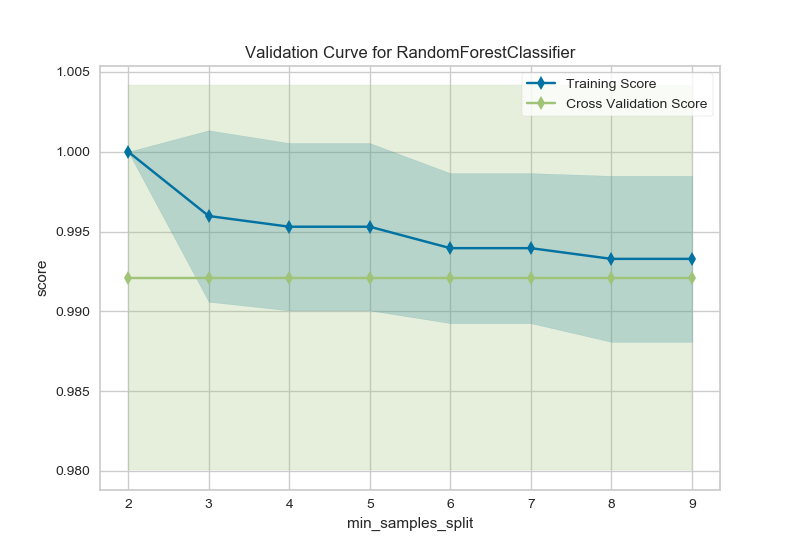

In [54]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_split',
    param_range = np.arange(2, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

#### Minimum Samples per Leaf

<IPython.core.display.Javascript object>


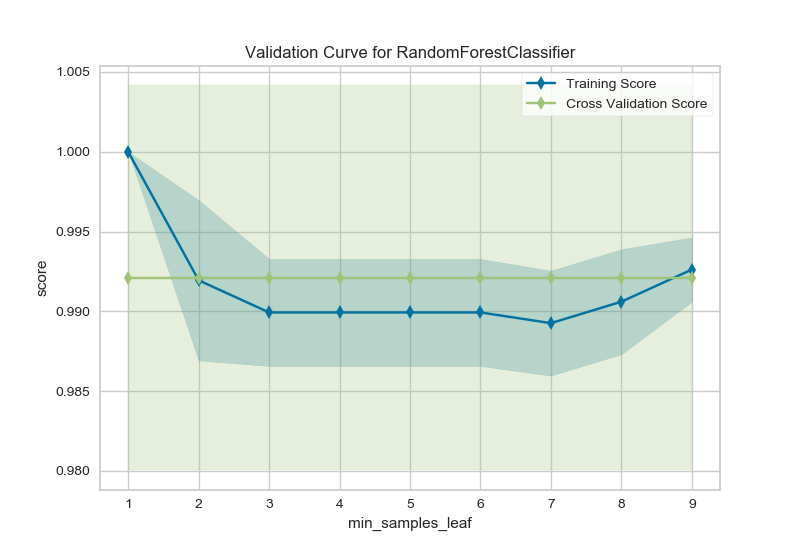

In [55]:
# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Create the validation curve visualizer
viz = ValidationCurve(
    RandomForestClassifier(random_state = 1), param_name = 'min_samples_leaf',
    param_range = np.arange(1, 10), 
    cv = cv, scoring = 'accuracy', n_jobs = -1,
)

viz.fit(X_train_cluster, y_train_cluster)
viz.poof()

<a href="#top">Back to Top</a> 
<a id="Model1"></a>
## EVALUATE AND COMPARE (10 points)

### Clustering Results on Feature Columns

|  Model #  | Cluster Algorithm | Data Instances | Cluster Size | Silhouette Score | Accuracy Score |
|:---------:|:-----------------:|:--------------:|:-----------:|:----------------:|----------------|
| Cluster 1 |      K-Means      |  All Quartiles |      2      |       0.364      | 0.696          |
| Cluster 2 |  MiniBatchK-Means |  All Quartiles |      2      |       0.365      | 0.682          |
| Cluster 3 |       DBSCAN      |  All Quartiles |     N/A     |       0.220      | 0.659          |
| Cluster 4 |   Agglomerative   |  All Quartiles |      2      |       0.500      | 0.655          |

### Clustering on Top and Bottom Quartiles of Schools, based on ACT Scores

|  Model #  | Cluster Algorithm |        Data Instances       | Kernel Size | Silhouette Score | Accuracy Score |
|:---------:|:-----------------:|:---------------------------:|:-----------:|:----------------:|----------------|
| Cluster 5 |      K-Means      | Top & Bottom Quartiles Only |      2      |       0.502      | 0.985          |
| Cluster 6 |  MiniBatchK-Means | Top & Bottom Quartiles Only |      2      |       0.501      | 0.987          |
| Cluster 7 |       DBSCAN      | Top & Bottom Quartiles Only |     N/A     |       0.081      | 0.983          |
| Cluster 8 |   Agglomerative   | Top & Bottom Quartiles Only |      2      |       0.497      | 0.987          |

### Random Forest Tuning

|    Model   |              Data Instances             | Estimator | Depth | Min Samples | Min Samples Leaf |
|:----------:|:---------------------------------------:|:---------:|:-----:|:-----------:|:----------------:|
| RF Model 1 | All Quartiles                           |       200 |   N/A |           8 |                9 |
| RF Model 2 | Top & Bottom Quartiles                  |       N/A |   N/A |         N/A |                3 |
| RF Model 3 | Top, Bottom Quartiles, & Cluster Labels |       200 |   N/A |         N/A |              N/A |

### RF Model Comparison Results

|    Model   |              Data Instances             | Accuracy | Precision | Recall | f1 Score |
|:----------:|:---------------------------------------:|:--------:|:---------:|:------:|:--------:|
| RF Model 1 | All Quartiles                           |    0.732 |     0.733 |  0.725 |    0.725 |
| RF Model 2 | Top & Bottom Quartiles                  |        1 |         1 |      1 |        1 |
| RF Model 3 | Top, Bottom Quartiles, & Cluster Labels |        1 |         1 |      1 |        1 |

### RF Model Evaluation

In [54]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'log2', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(70, 140, num = 8)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 12]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#### RF Model 1

In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = 24)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_randomCV = RandomizedSearchCV(estimator = rfc, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = cv, verbose = 2, 
                                  random_state = 18, n_jobs = -1, 
                                  scoring = 'accuracy')

# Fit the random search model
rfc_randomCV.fit(X_train_Dropped, y_train_Dropped)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
          error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'log2', 'sqrt'], 'max_depth': [70, 80, 90, 100, 110, 120, 130, 140, None], 'min_samples_split': [2, 4, 6, 12], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=18, refit=Tru

In [58]:
# examine the best model
print(rfc_randomCV.best_score_)
print(rfc_randomCV.best_params_)
print(rfc_randomCV.best_estimator_)

0.7324324324324324
{'n_estimators': 1200, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 140, 'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=140, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


Best parameters set found on development set: {'n_estimators': 1200, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 140, 'bootstrap': True}


<IPython.core.display.Javascript object>


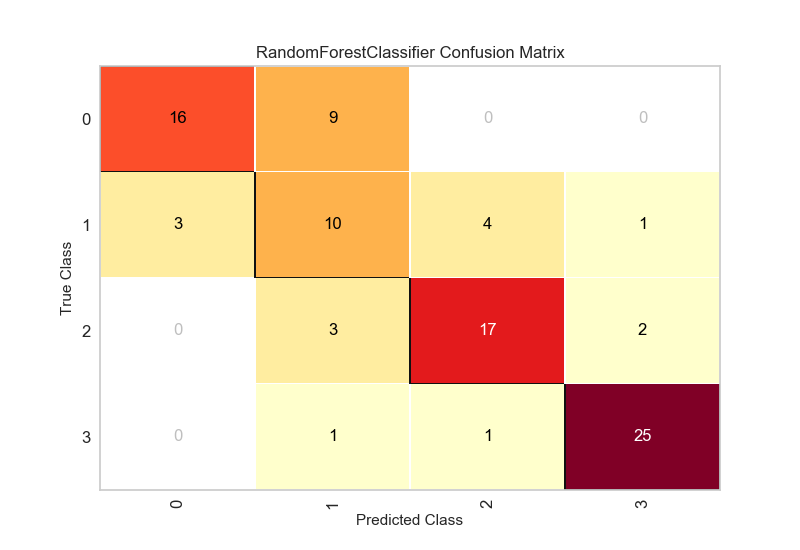

<IPython.core.display.Javascript object>


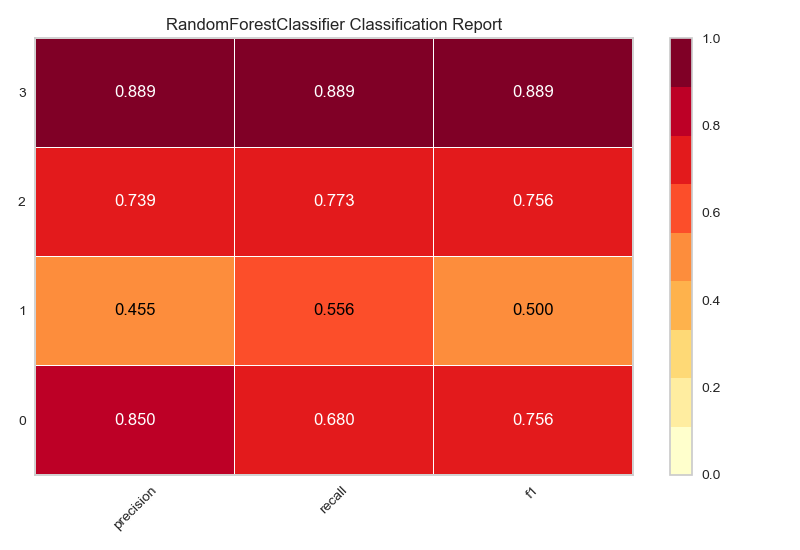

<IPython.core.display.Javascript object>


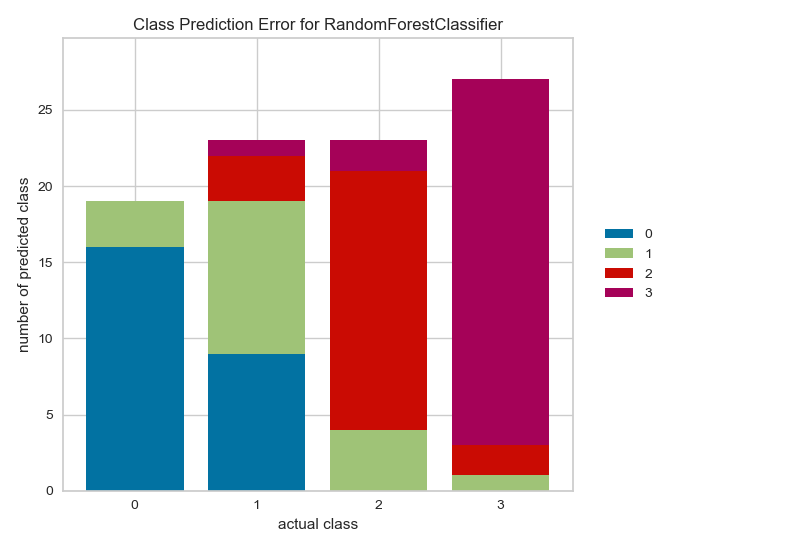

In [59]:
# get best parameters from the gridsearch for the all quartile model
bestValues = rfc_randomCV.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = RandomForestClassifier(bootstrap = bestValues['bootstrap'], 
                             max_depth = bestValues['max_depth'], 
                             max_features = bestValues['max_features'], 
                             min_samples_leaf = bestValues['min_samples_leaf'], 
                             min_samples_split = bestValues['min_samples_split'], 
                             n_estimators = bestValues['n_estimators'])

classFit = cls.fit(X_train_Dropped, y_train_Dropped)

y_hat = cls.predict(X_test_Dropped)

# Train
cm = ConfusionMatrix(classFit)

# Predict test values
cm.predict(X_test_Dropped)

cm.score(X_test_Dropped, y_test_Dropped)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Classification Report
vis = ClassificationReport(cls)
vis.fit(X_train_Dropped, y_train_Dropped)
vis.score(X_test_Dropped, y_test_Dropped)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Prediction Error Report
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train_Dropped, y_train_Dropped)

# Evaluate the model on the test data
vis.score(X_test_Dropped, y_test_Dropped)

# Draw visualization
vis.poof()

<IPython.core.display.Javascript object>


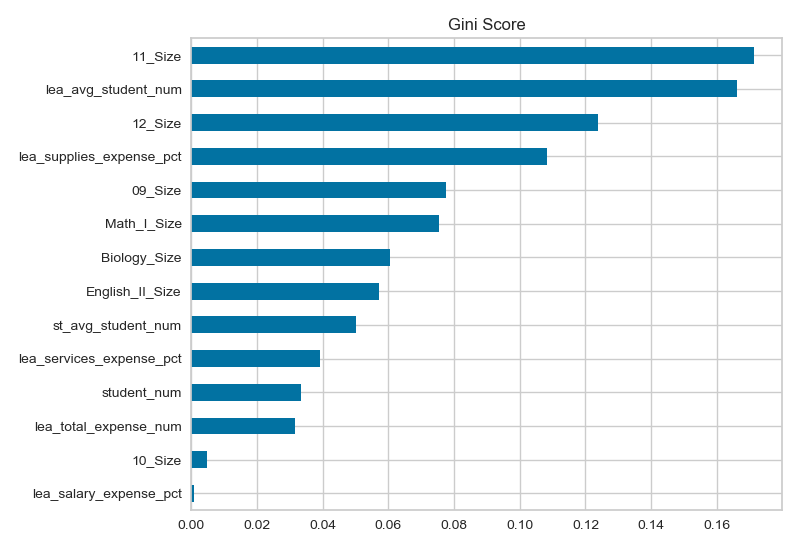

In [60]:
#feature importance of all quartile classification model

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

clf.fit(X_Dropped, y_Dropped)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(dfDropped.columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='barh', legend = False,
                                                  title = 'Gini Score')
plt.tight_layout()

#### RF Model 2

In [61]:
X_extreme = dfExtremes[featCols]
y_extreme = dfExtremes['ACT_Score_Quartiles']

X_train_extreme, X_test_extreme, y_train_extreme, y_test_extreme = train_test_split(X_extreme, y_extreme, random_state=42, test_size=.2)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = 24)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_randomCV2 = RandomizedSearchCV(estimator = rfc, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = cv, verbose = 2, 
                                  random_state = 18, n_jobs = -1, 
                                  scoring = 'accuracy')

# Fit the random search model
rfc_randomCV2.fit(X_train_extreme, y_train_extreme)

# examine the best model
print(rfc_randomCV2.best_score_)
print(rfc_randomCV2.best_params_)
print(rfc_randomCV2.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.4min finished


1.0
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


In [62]:
# examine the best model
print(rfc_randomCV2.best_score_)
print(rfc_randomCV2.best_params_)
print(rfc_randomCV2.best_estimator_)

1.0
{'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=90, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


Best parameters set found on development set: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


<IPython.core.display.Javascript object>


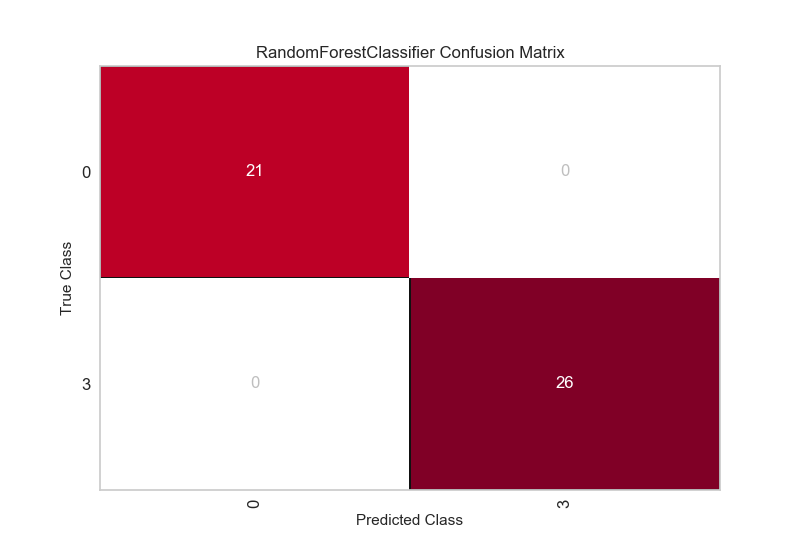

<IPython.core.display.Javascript object>


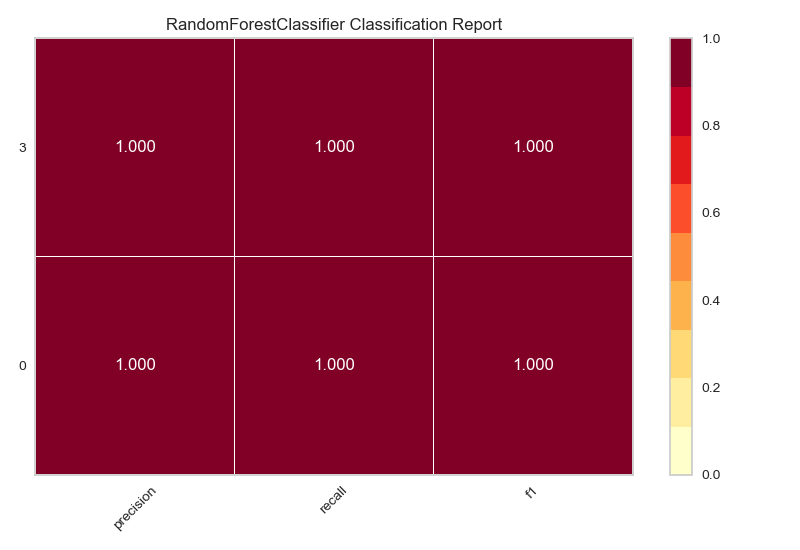

<IPython.core.display.Javascript object>


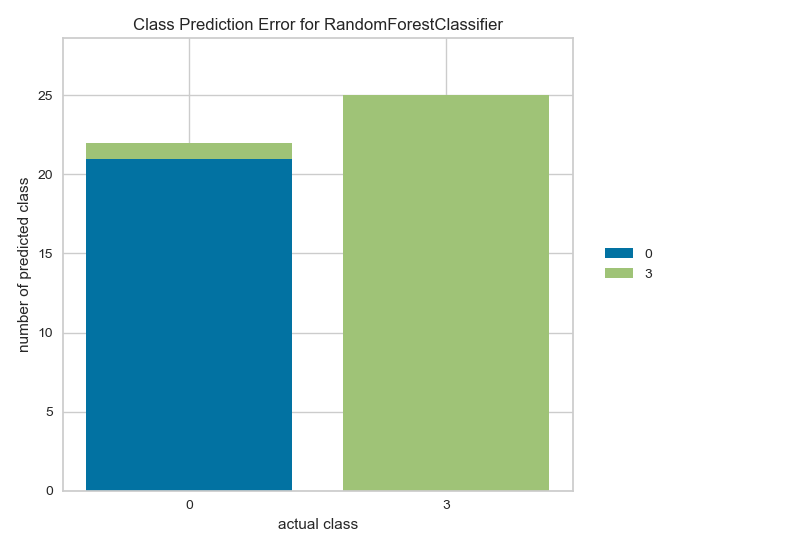

In [63]:
# get best parameters from the gridsearch for the all quartile model
bestValues = rfc_randomCV2.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = RandomForestClassifier(bootstrap = bestValues['bootstrap'], 
                             max_depth = bestValues['max_depth'], 
                             max_features = bestValues['max_features'], 
                             min_samples_leaf = bestValues['min_samples_leaf'], 
                             min_samples_split = bestValues['min_samples_split'], 
                             n_estimators = bestValues['n_estimators'])

classFit = cls.fit(X_train_extreme, y_train_extreme)

y_hat = cls.predict(X_test_extreme)

# Train
cm = ConfusionMatrix(classFit)

# Predict test values
cm.predict(X_test_extreme)

cm.score(X_test_extreme, y_test_extreme)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Classification Report
vis = ClassificationReport(cls)
vis.fit(X_train_extreme, y_train_extreme)
vis.score(X_test_extreme, y_test_extreme)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Prediction Error Report
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train_extreme, y_train_extreme)

# Evaluate the model on the test data
vis.score(X_test_extreme, y_test_extreme)

# Draw visualization
vis.poof()

<IPython.core.display.Javascript object>


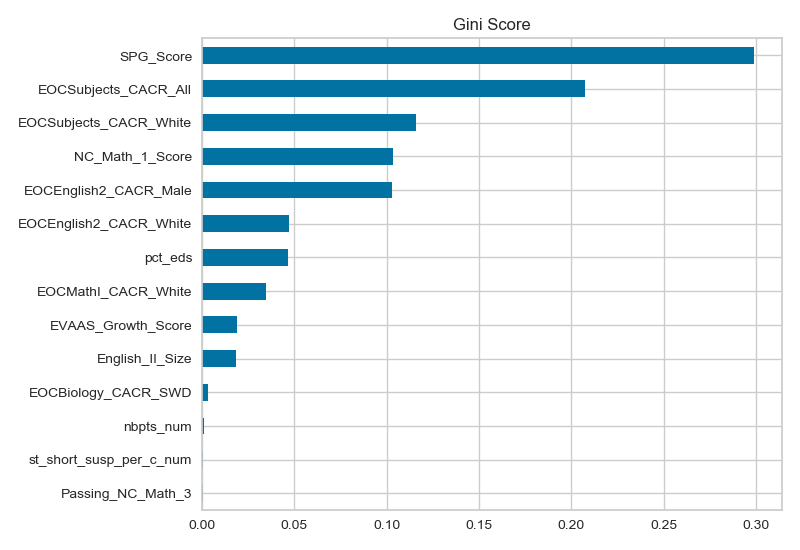

In [64]:
#feature importance of all quartile classification model

clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

clf.fit(X_extreme, y_extreme)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(dfExtremes[featCols].columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='barh', legend = False,
                                                  title = 'Gini Score')
plt.tight_layout()

#### RF Model 3

In [65]:
# This includes dfDropped[featCols] + clustering labels
X_Cluster = dfCluster

# Just look at the Q1 and Q4 data
y_Cluster = dfExtremes['ACT_Score_Quartiles']

X_train_Cluster, X_test_Cluster, y_train_Cluster, y_test_Cluster = train_test_split(X_Cluster, y_Cluster, random_state=42, test_size=.2)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier(random_state = 24)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_randomCV3 = RandomizedSearchCV(estimator = rfc, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = cv, verbose = 2, 
                                  random_state = 18, n_jobs = -1, 
                                  scoring = 'accuracy')

# Fit the random search model
rfc_randomCV3.fit(X_train_Cluster, y_train_Cluster)

# examine the best model
print(rfc_randomCV3.best_score_)
print(rfc_randomCV3.best_params_)
print(rfc_randomCV3.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   51.2s


0.9947368421052631
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished


In [66]:
# Create the parameter grid based on the results of random search
# based on the cluster extreme model
param_grid = {
    'bootstrap': [False],
    'max_depth': [135, 140, 145],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2, 3],
    'n_estimators': [725, 750, 775, 800, 825, 850, 875]
}

# Create a based model
rfc = RandomForestClassifier(random_state = 24)

# Instantiate the grid search model
rfc_gridCV3 = GridSearchCV(estimator = rfc, param_grid = param_grid, 
                                cv = cv, n_jobs = -1, verbose = 2, 
                                scoring = 'accuracy')

# Fit the grid search to the data
rfc_gridCV3.fit(X_train_Cluster, y_train_Cluster)

# examine the best model
print(rfc_gridCV3.best_score_)
print(rfc_gridCV3.best_params_)
print(rfc_gridCV3.best_estimator_)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   28.0s finished


0.9921052631578947
{'bootstrap': False, 'max_depth': 135, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 725}
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=135, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=725, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)


Best parameters set found on development set: {'bootstrap': False, 'max_depth': 135, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 725}


<IPython.core.display.Javascript object>


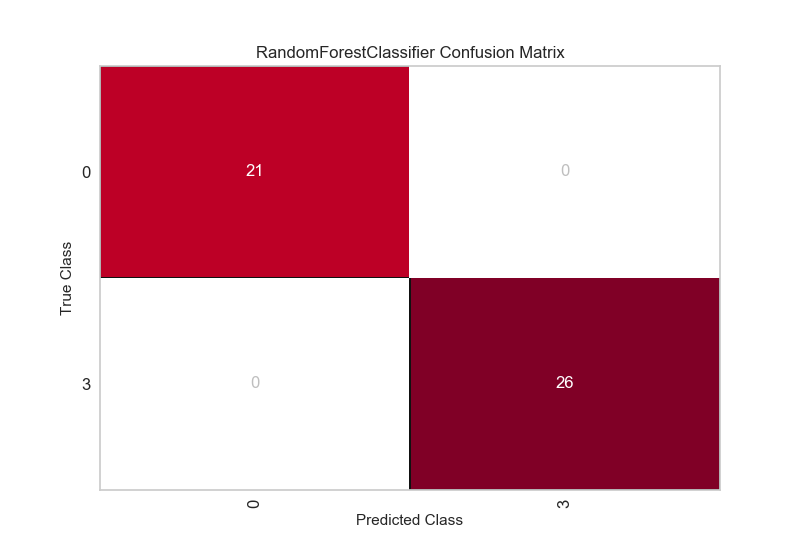

<IPython.core.display.Javascript object>


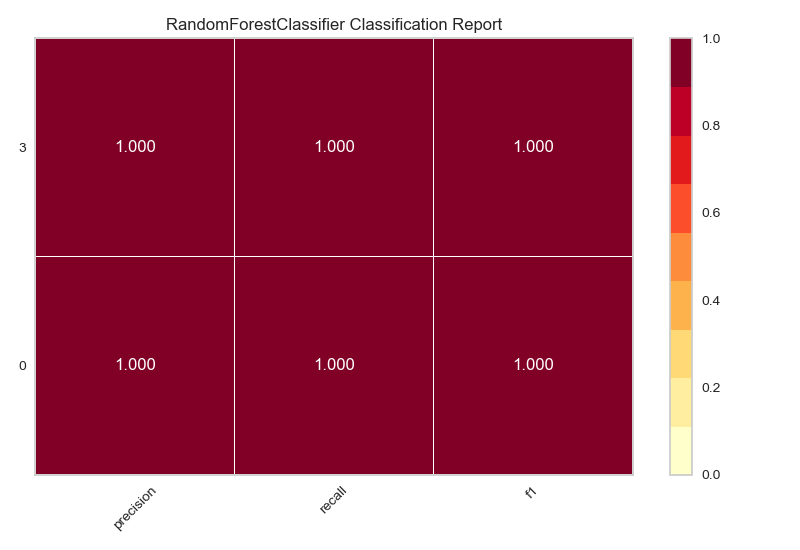

<IPython.core.display.Javascript object>


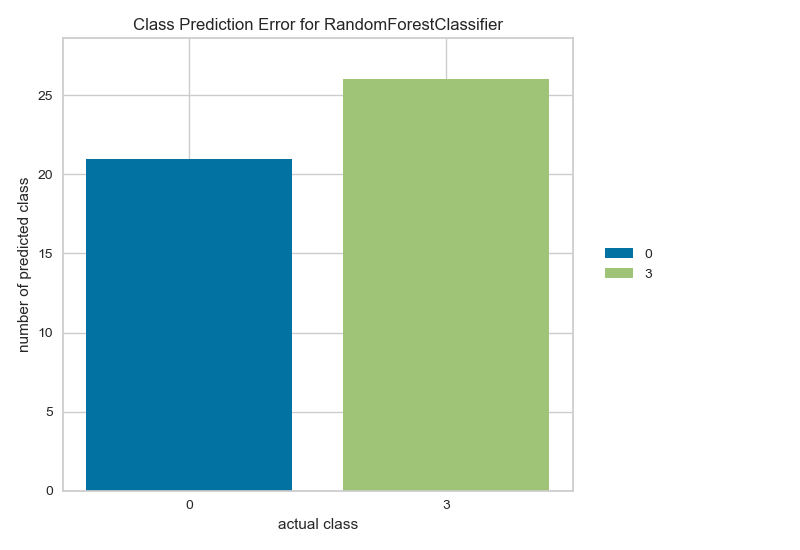

In [67]:
# get best parameters from the gridsearch for the clustered model of Q1 vs Q4
bestValues = rfc_gridCV3.best_params_

print("Best parameters set found on development set: {}".format(bestValues))

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Set model to best values found
cls = RandomForestClassifier(bootstrap = bestValues['bootstrap'], 
                             max_depth = bestValues['max_depth'], 
                             max_features = bestValues['max_features'], 
                             min_samples_leaf = bestValues['min_samples_leaf'], 
                             min_samples_split = bestValues['min_samples_split'], 
                             n_estimators = bestValues['n_estimators'])

classFit = cls.fit(X_train_Cluster, y_train_Cluster)

y_hat = cls.predict(X_test_Cluster)

# Train
cm = ConfusionMatrix(classFit)

# Predict test values
cm.predict(X_test_Cluster)

cm.score(X_test_Cluster, y_test_Cluster)

cm.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Classification Report
vis = ClassificationReport(cls)
vis.fit(X_train_Cluster, y_train_Cluster)
vis.score(X_test_Cluster, y_test_Cluster)
vis.poof()

# Create a new matplotlib figure
fig = plt.figure()
ax = fig.add_subplot()

# Prediction Error Report
vis = ClassPredictionError(cls)

# Fit the training data to the visualizer
vis.fit(X_train_Cluster, y_train_Cluster)

# Evaluate the model on the test data
vis.score(X_test_Cluster, y_test_Cluster)

# Draw visualization
vis.poof()

<IPython.core.display.Javascript object>


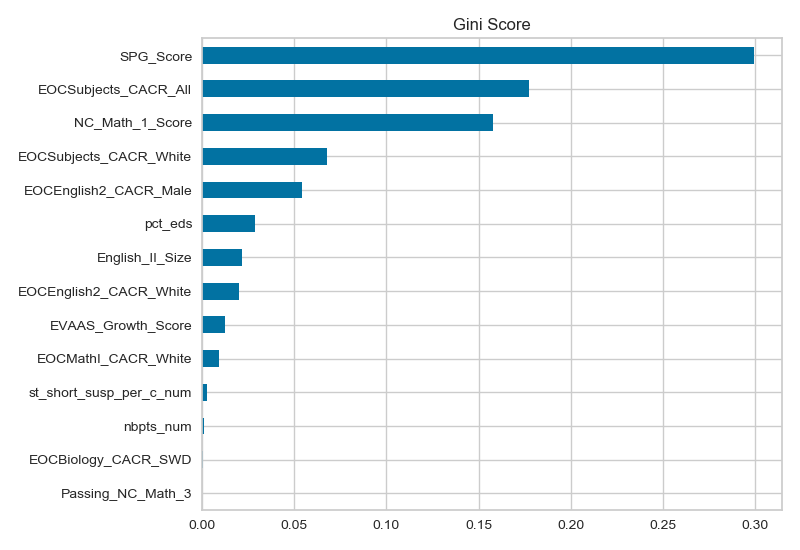

In [68]:
#feature analysis of clustered RF model

clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=135, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=24, verbose=0, warm_start=False)

clf.fit(X_Cluster, y_Cluster)

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(dfExtremes[featCols].columns, clf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='barh', legend = False,
                                                  title = 'Gini Score')
plt.tight_layout()

<a href="#top">Back to Top</a> 
<a id="Model3"></a>
## VISUALIZE RESULTS (10 points)

In [69]:
model = MiniBatchKMeans(n_clusters = 2, random_state = 42)
model.fit(dfExtremes[featCols])
cLabels = model.labels_

dfCluster = dfExtremes[featCols].join(pd.get_dummies(cLabels))

X_cluster = dfCluster

y_cluster = dfExtremes['ACT_Score_Quartiles']

dfCluster.drop(dfCluster.columns[[-1,-2,-3,-4]], axis = 1, inplace = True)

<IPython.core.display.Javascript object>


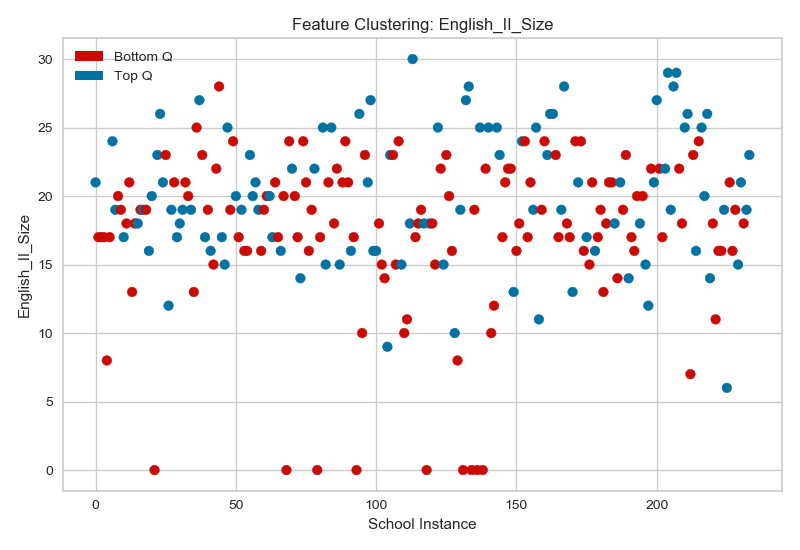

<IPython.core.display.Javascript object>


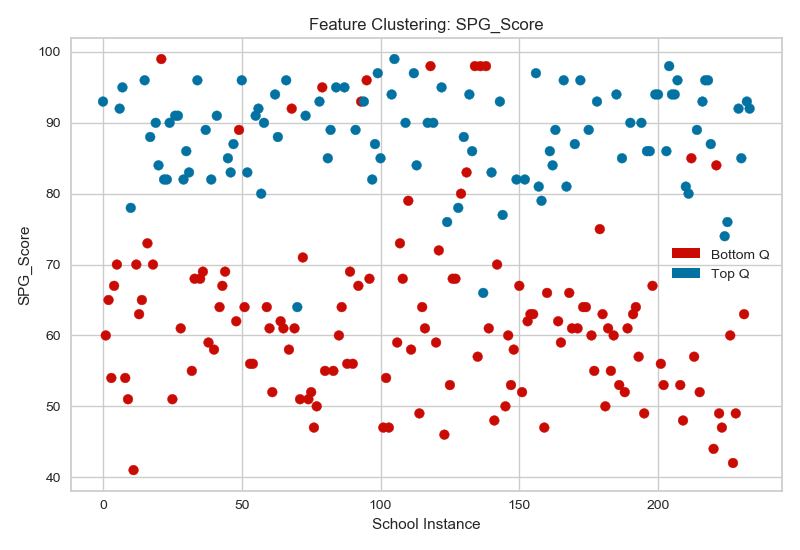

<IPython.core.display.Javascript object>


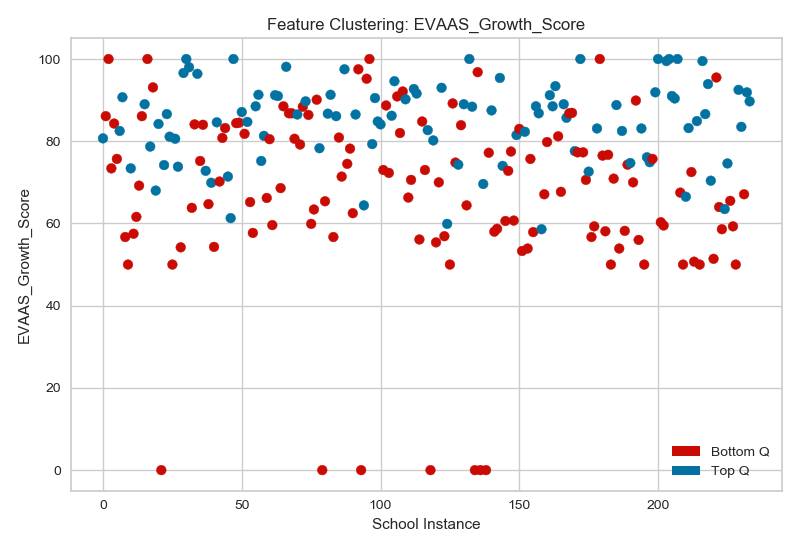

<IPython.core.display.Javascript object>


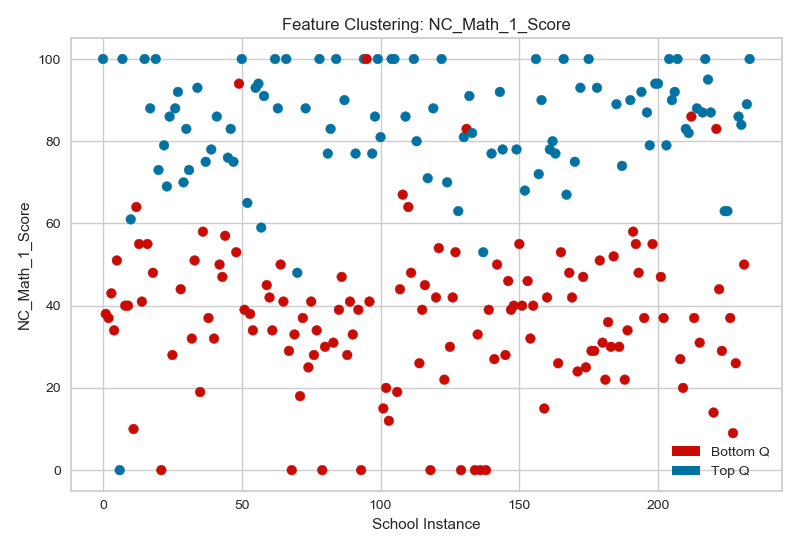

<IPython.core.display.Javascript object>


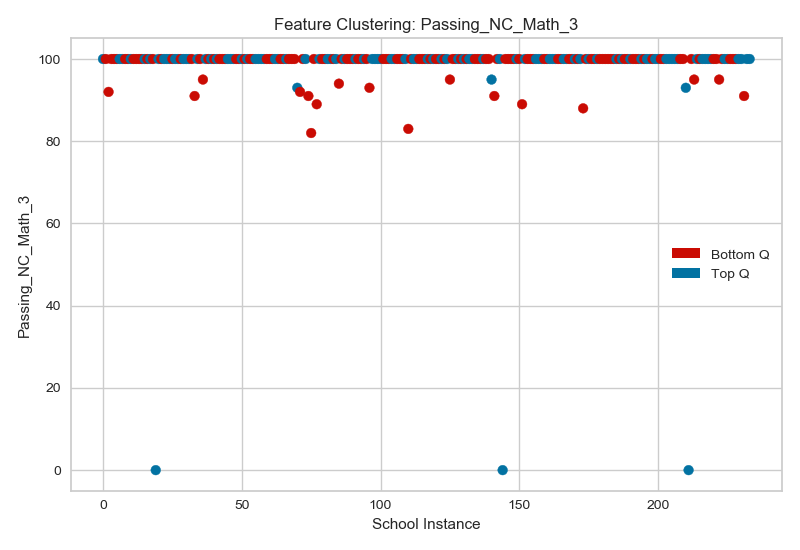

<IPython.core.display.Javascript object>


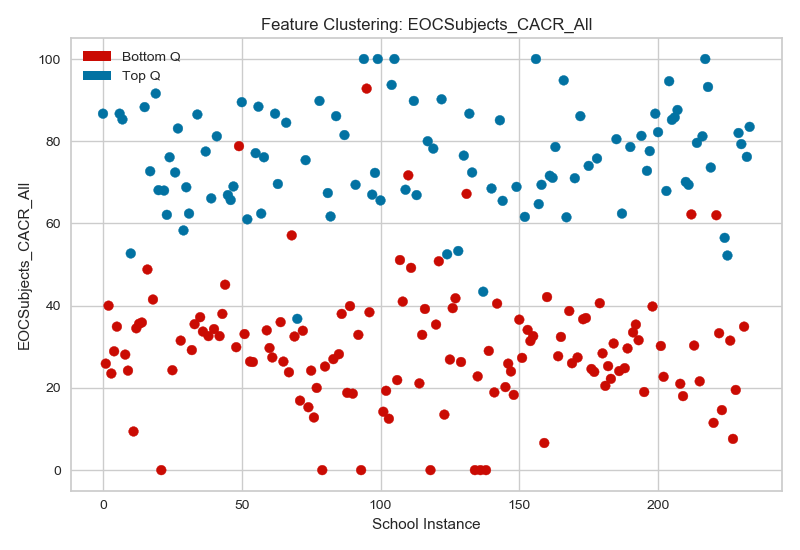

<IPython.core.display.Javascript object>


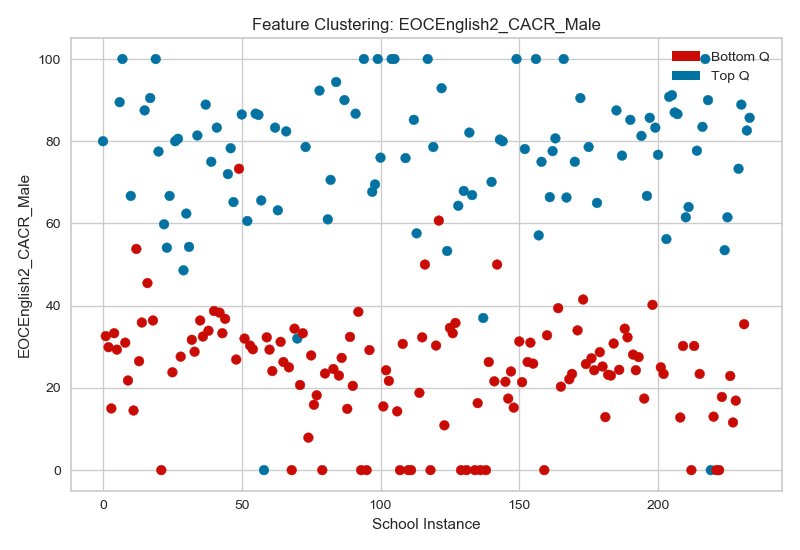

<IPython.core.display.Javascript object>


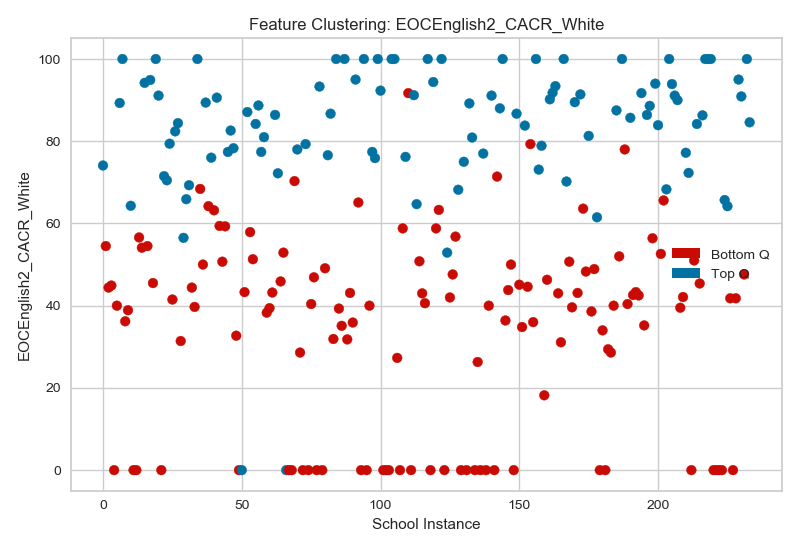

<IPython.core.display.Javascript object>


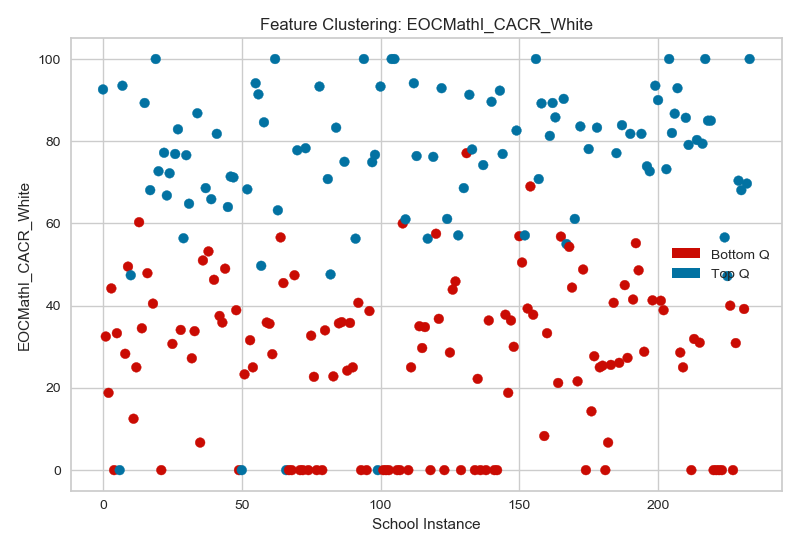

<IPython.core.display.Javascript object>


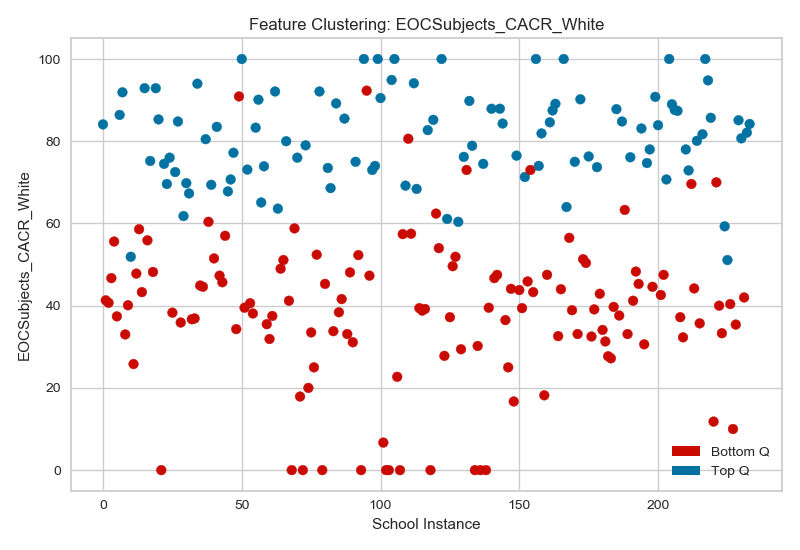

<IPython.core.display.Javascript object>


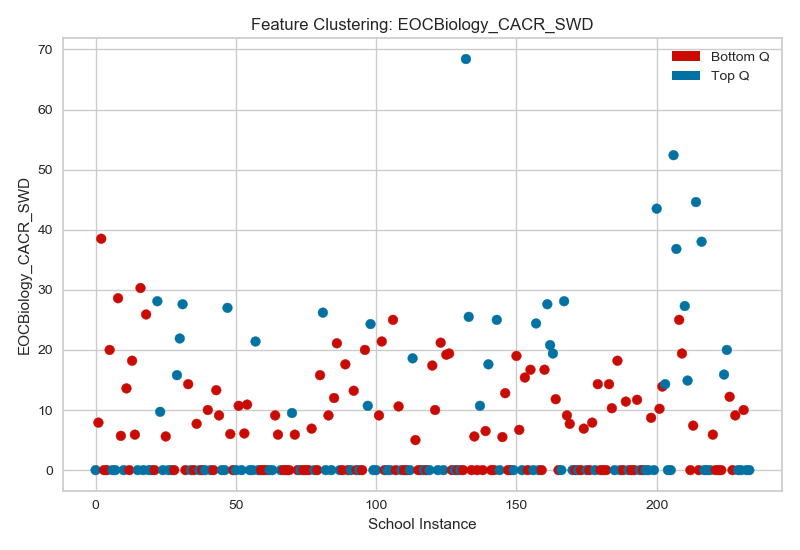

<IPython.core.display.Javascript object>


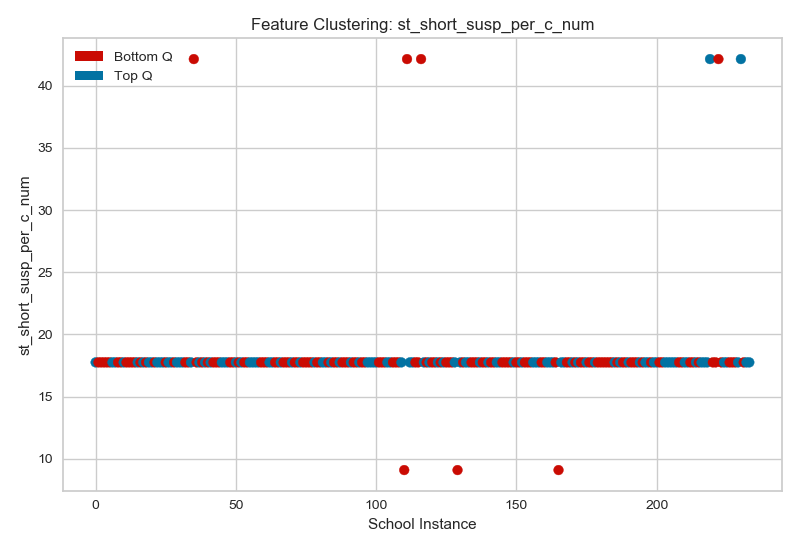

In [71]:
# Credit: https://stackoverflow.com/questions/26558816/matplotlib-scatter-plot-with-legend/26559256
# Credit: https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale
import matplotlib.patches as mpatches
import matplotlib.colors

dataRows = np.arange(0, dfCluster.shape[0])

classes = ['Bottom Q', 'Top Q']
class_colors = ['r', 'b']
recs = []
for i in range(0, len(class_colors)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["r","b"])

for col in dfCluster:
    plt.figure()
    plt.scatter(dataRows, dfCluster[col], c=cLabels, cmap=cmap)
    plt.title("Feature Clustering: {}".format(col))
    plt.xlabel("School Instance")
    plt.ylabel(col)
    plt.legend(recs, classes)
    
    plt.tight_layout()

<IPython.core.display.Javascript object>


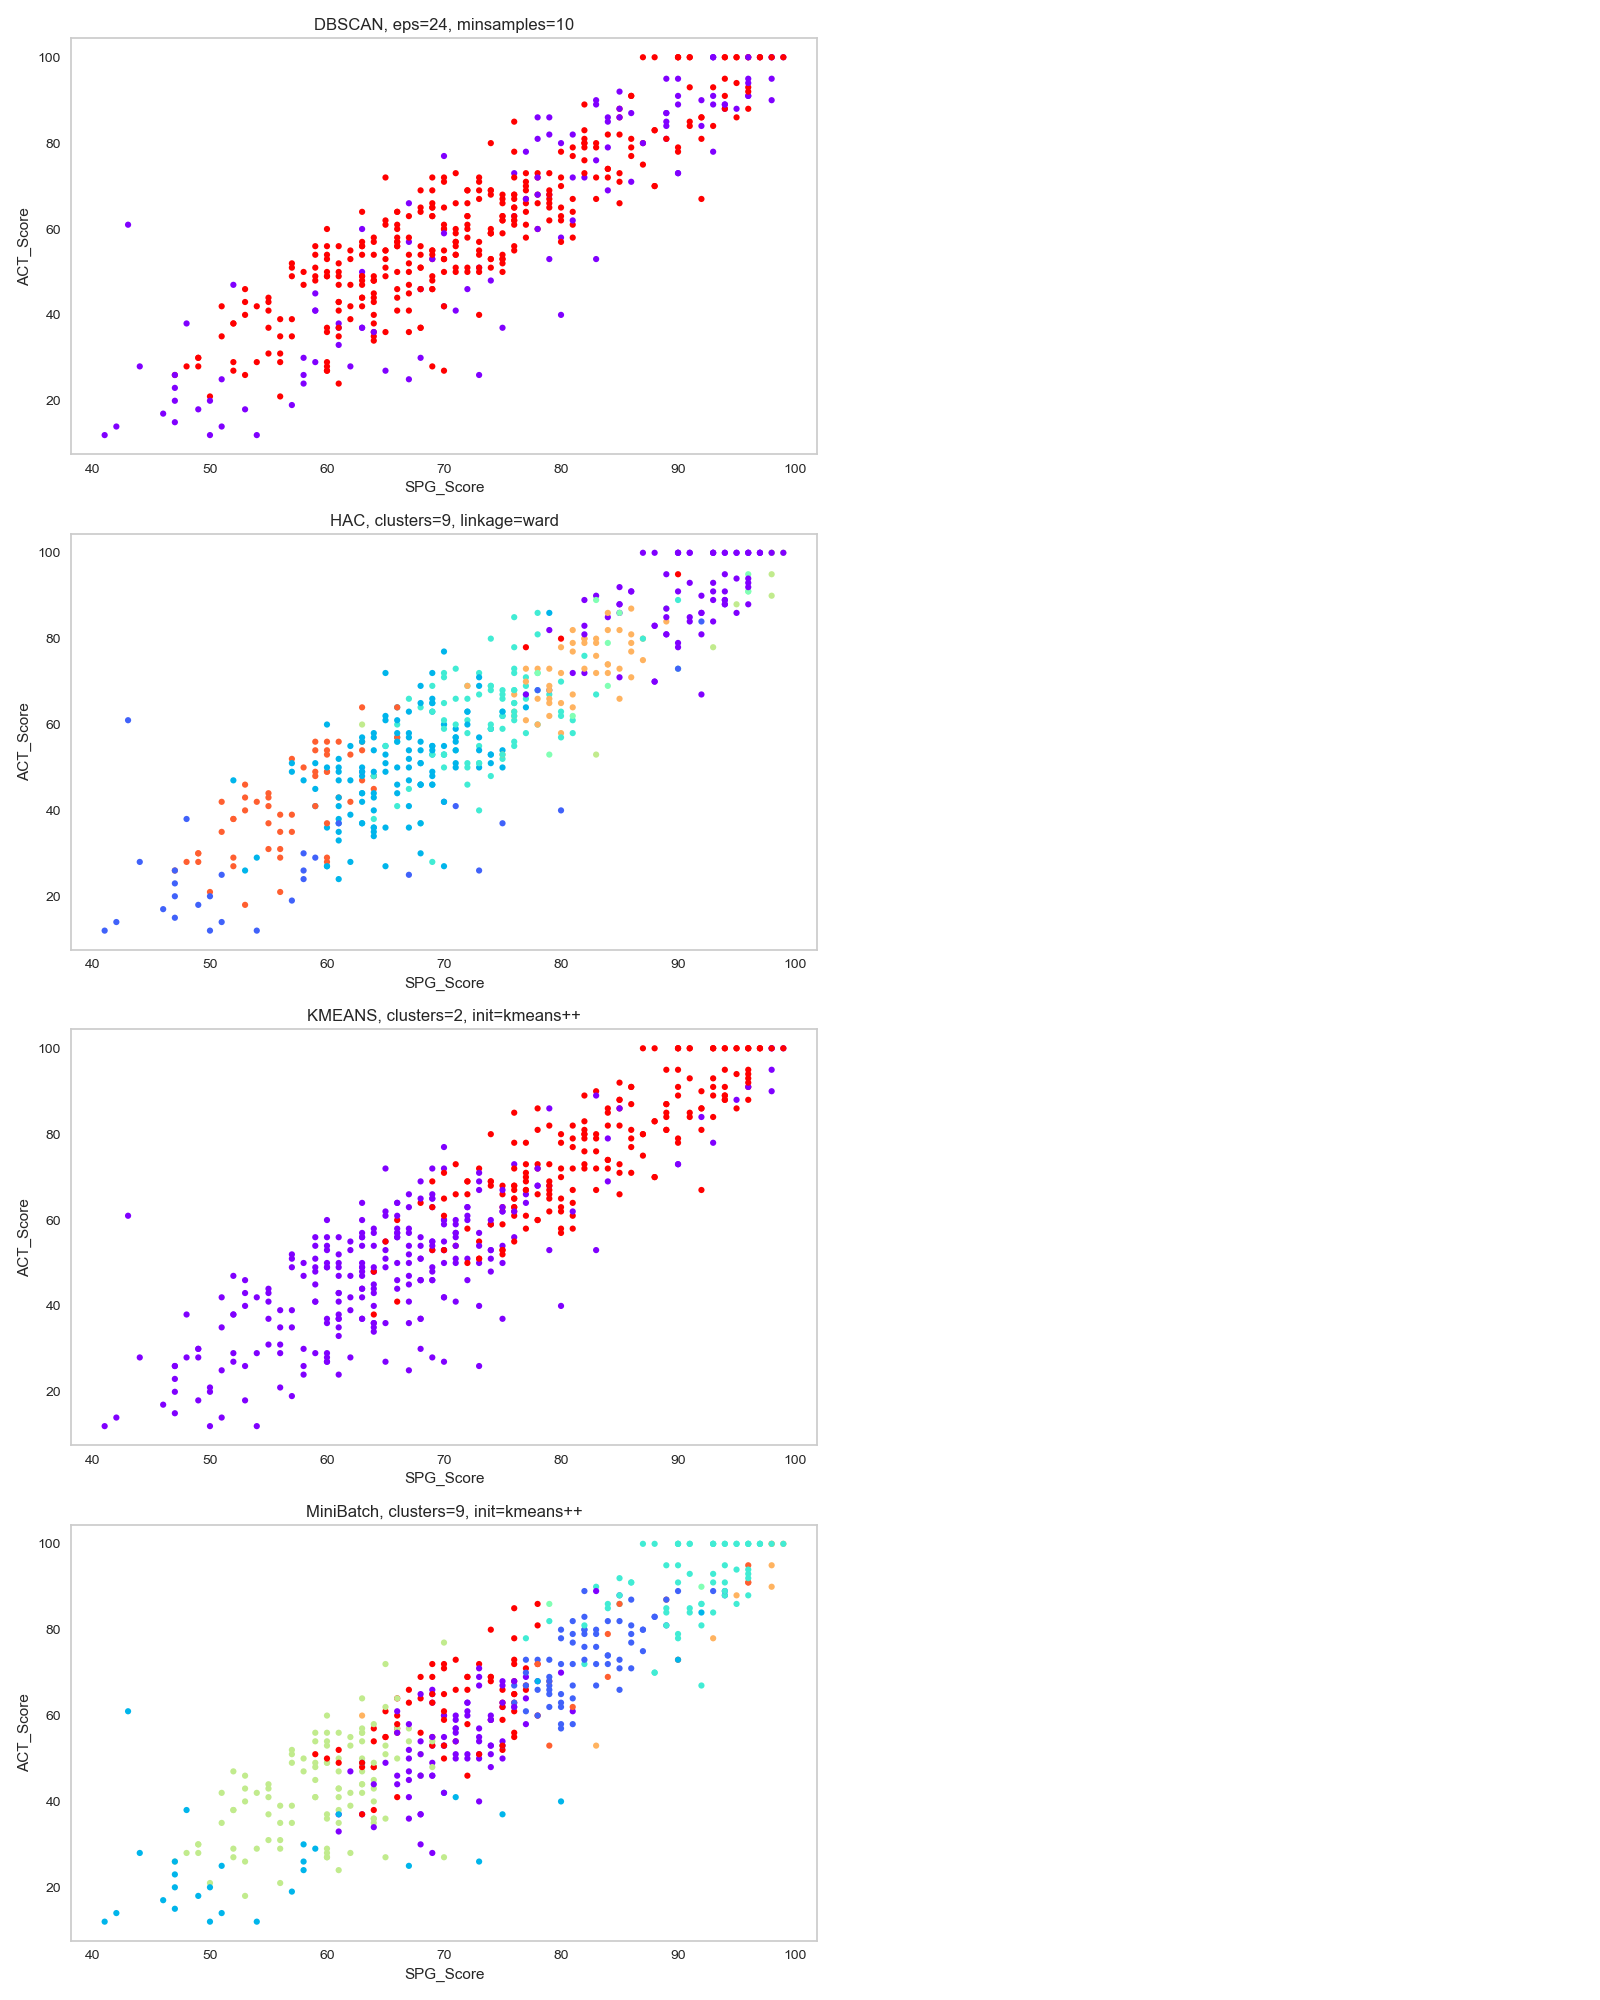

In [52]:
#let's visualize how the clustering looks on one of the same correlated
#variables we looked at in our initial explaratory data analysis (spg score)

# training data
X_Dropped = dfDropped[featCols]

# target variable
y_Dropped = dfDropped['ACT_Score_Quartiles']

#all quartile best models first
kmeans_AllQ = KMeans(n_clusters=2, init='k-means++',random_state=42)
kmeans_AllQ.fit(X_Dropped)
kmeans_AllQ_labels = kmeans_AllQ.labels_ # the labels from kmeans clustering

minibkmeans_AllQ = MiniBatchKMeans(n_clusters=9, init='k-means++',random_state=42)
minibkmeans_AllQ.fit(X_Dropped)
minibkmeans_AllQ_labels = minibkmeans_AllQ.labels_ # the labels from kmeans clustering

dbs_AllQ =  DBSCAN(eps=24, min_samples = 10)
dbs_AllQ.fit(X_Dropped)
dbs_AllQ_labels = dbs_AllQ.labels_

aggc_AllQ = AgglomerativeClustering(n_clusters=9, linkage='ward')
aggc_AllQ.fit(X_Dropped)
aggc_AllQ_labels = aggc_AllQ.labels_


fig = plt.figure(figsize=(16,20))
title = ['DBSCAN, eps=24, minsamples=10',
         'HAC, clusters=9, linkage=ward',
         'KMEANS, clusters=2, init=kmeans++',
         'MiniBatch, clusters=9, init=kmeans++']

for i,l in enumerate([dbs_AllQ_labels, aggc_AllQ_labels, kmeans_AllQ_labels, minibkmeans_AllQ_labels]):
    
    plt.subplot(4,2,2*i+1)
    plt.scatter(x=dfDropped['SPG_Score'], y=dfDropped['ACT_Score'], c=l, 
                cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('SPG_Score'), plt.ylabel('ACT_Score')
    plt.grid()
    plt.title(title[i])

plt.tight_layout()
plt.show()


We'll visualize how each algorithm clustered based on what RF model yielded the most accurate model from their clustering labels. First we'll look at the models that had to classify each of the four quartiles of average ACT scores at a given school. We'll look at one of our original featured variables SPG score that was highly correlated with ACT score make the visualization easier.

For DBSCAN with eps = 24 and min_samples = 10 we get only 2 clusters that yielded the most accurate RF model (0.6587). They are dispersed evenly throughout the graph, clearly this variable is not what was used to separate the clusters due to their density overlapping with one another.

For Heirarchical Agglomerative Clustering (HAC), cluster = 9 and ward linkage yielded the most accurate RF model (0.6554). This graph looks somewhat like our original color coded quartile scatter plot with a few extra labels clustered throughout.

For KMeans, cluster = 2 and initialization of KMeans++ yielded the most accurate RF model (0.6815). Unlike DBSCAN, this algorithm clustered the data approximately in half on the ACT scores with some overlap.

For MiniBatchKMeans, clusters = 9 and initialization of KMeans++ yielded the most accurate RF model (0.6957). This looks like data was approximately clustered into 6 main clusters over the ACT scores with what looks like the top quartile being clustered in many ways.

<IPython.core.display.Javascript object>


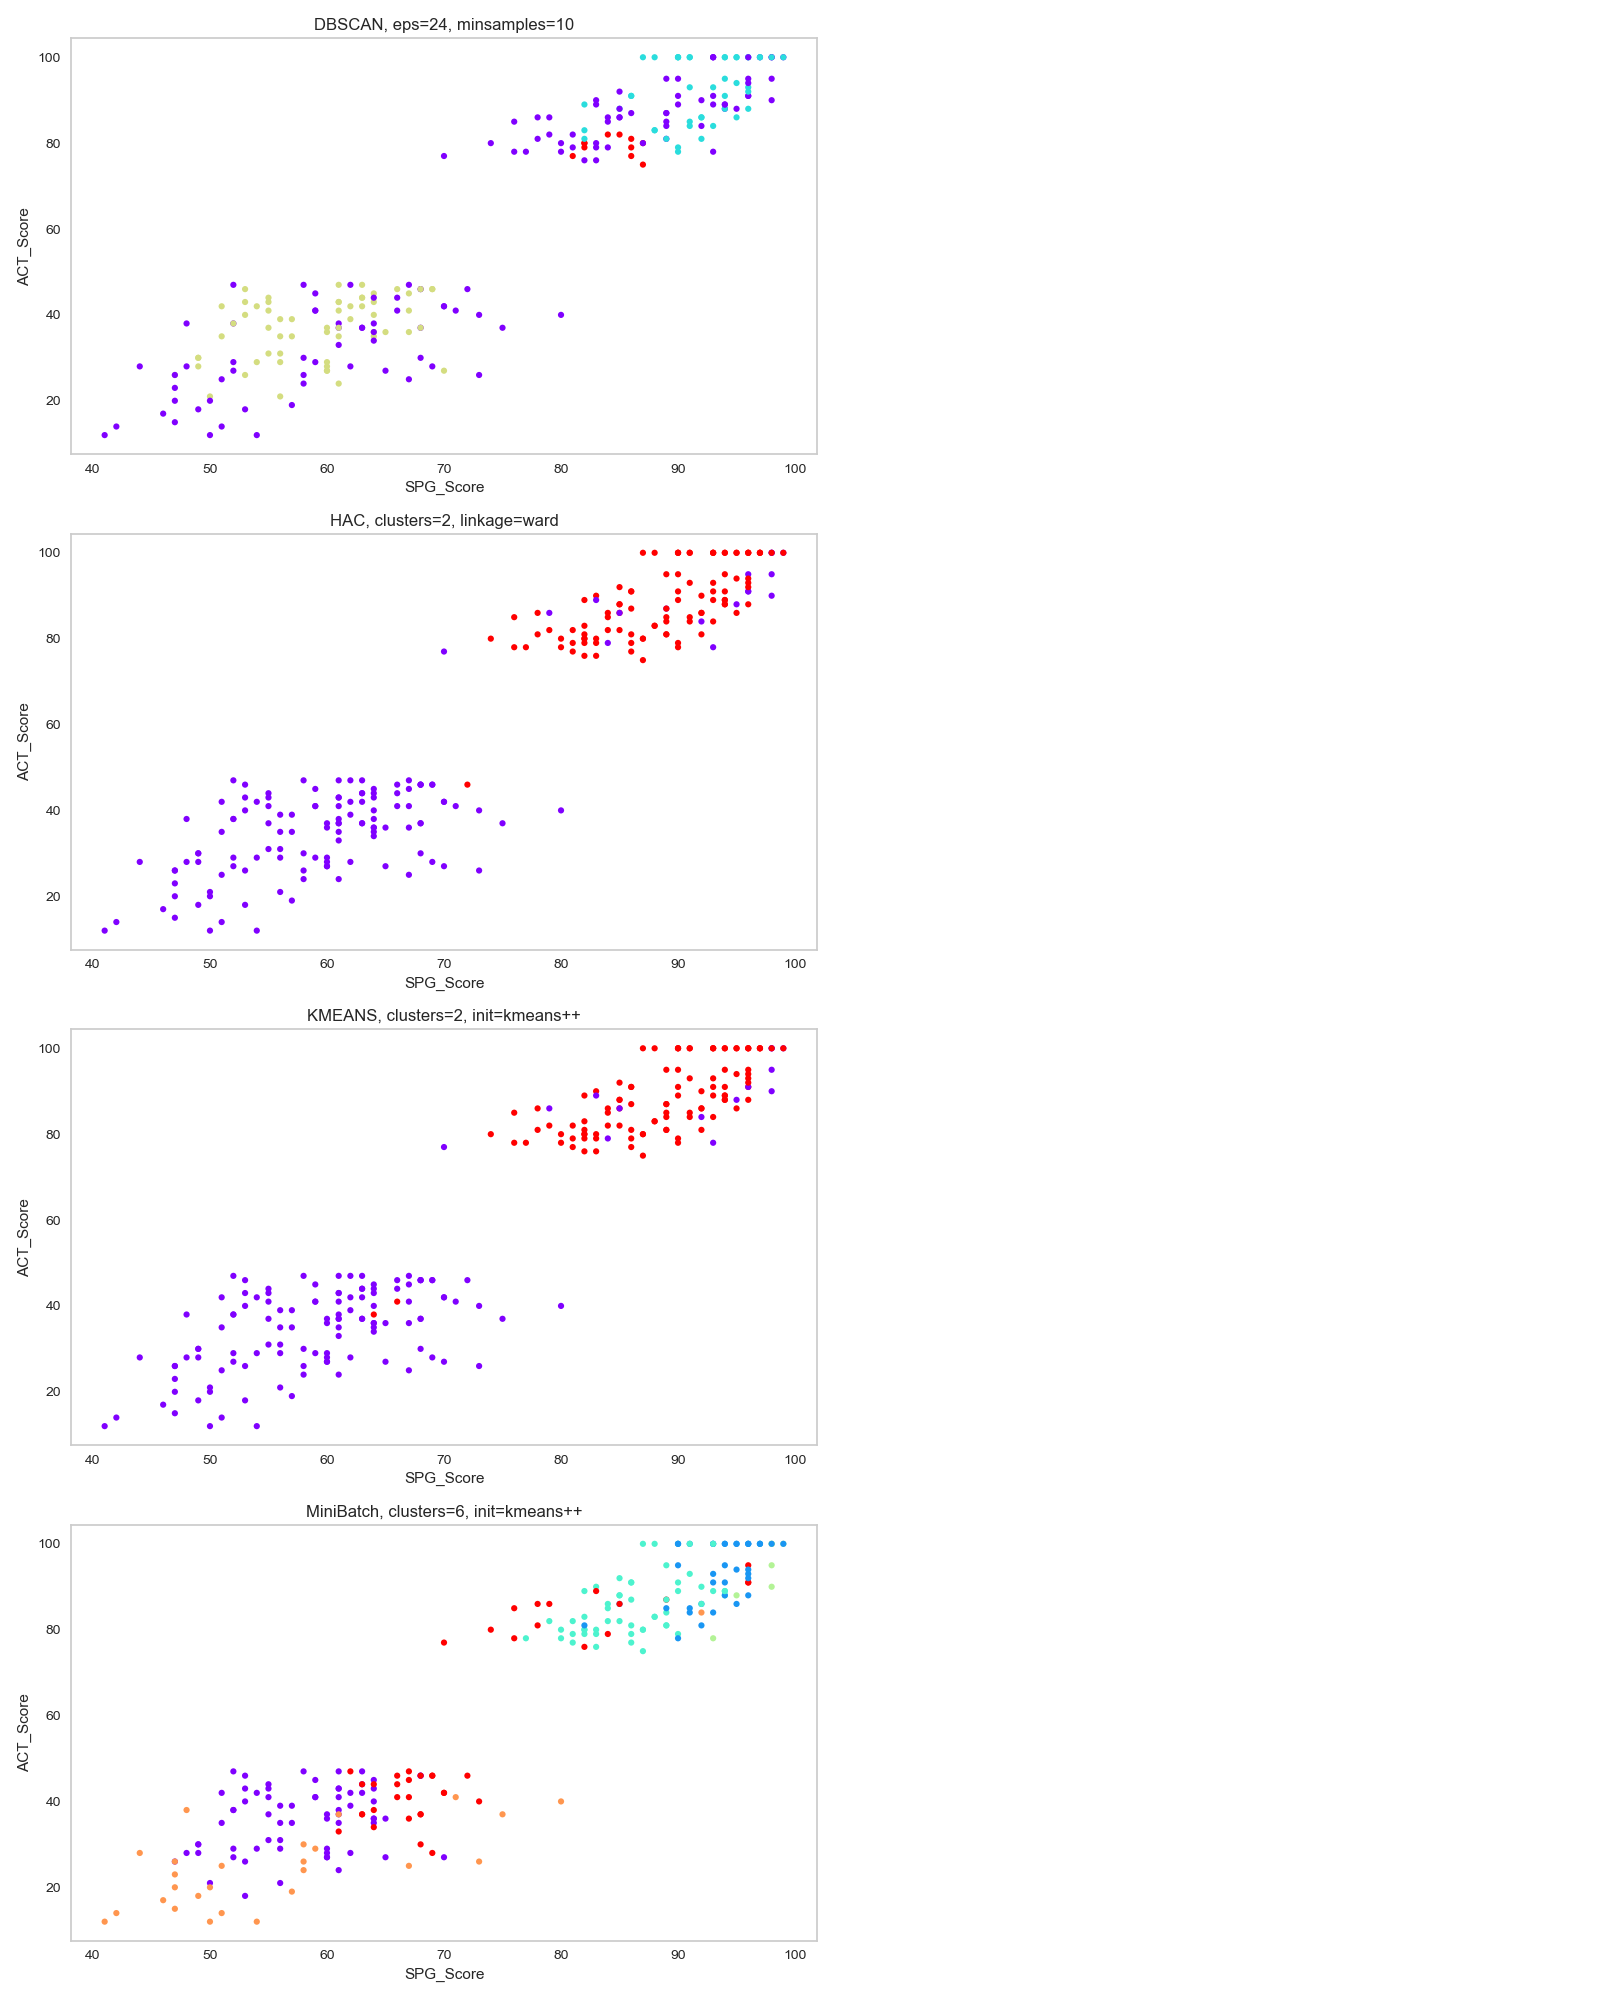

In [53]:
#all Q1 vs Q4 clustered classification models now
dfExtremes = dfDropped[(dfDropped['ACT_Score_Quartiles'] == 0) | (dfDropped['ACT_Score_Quartiles'] == 3)]

X_Extremes = dfExtremes[featCols]

y_Extremes = dfExtremes['ACT_Score_Quartiles']

kmeans_Q1Q4 = KMeans(n_clusters=2, init='k-means++',random_state=42)
kmeans_Q1Q4.fit(X_Extremes)
kmeans_Q1Q4_labels = kmeans_Q1Q4.labels_ # the labels from kmeans clustering

minibkmeans_Q1Q4 = MiniBatchKMeans(n_clusters=6, init='k-means++',random_state=42)
minibkmeans_Q1Q4.fit(X_Extremes)
minibkmeans_Q1Q4_labels = minibkmeans_Q1Q4.labels_ # the labels from kmeans clustering

dbs_Q1Q4 =  DBSCAN(eps=24, min_samples = 10)
dbs_Q1Q4.fit(X_Extremes)
dbs_Q1Q4_labels = dbs_Q1Q4.labels_

aggc_Q1Q4 = AgglomerativeClustering(n_clusters=2, linkage='ward')
aggc_Q1Q4.fit(X_Extremes)
aggc_Q1Q4_labels = aggc_Q1Q4.labels_


fig = plt.figure(figsize=(16,20))
title = ['DBSCAN, eps=24, minsamples=10',
         'HAC, clusters=2, linkage=ward',
         'KMEANS, clusters=2, init=kmeans++',
         'MiniBatch, clusters=6, init=kmeans++']

for i,l in enumerate([dbs_Q1Q4_labels, aggc_Q1Q4_labels, kmeans_Q1Q4_labels, minibkmeans_Q1Q4_labels]):
    
    plt.subplot(4,2,2*i+1)
    plt.scatter(x=dfExtremes['SPG_Score'], y=dfExtremes['ACT_Score'], c=l, 
                cmap=plt.cm.rainbow, s=20, linewidths=0)
    plt.xlabel('SPG_Score'), plt.ylabel('ACT_Score')
    plt.grid()
    plt.title(title[i])

plt.tight_layout()
plt.show()

Now let's visualize how each clustering algorithm clustered based on what RF model yielded the most accurate results from only a bottom quartile and top quartile classification model for the average ACT score at a given school.

For DBSCAN with eps = 24 and min_samples = 10 we get get 5 clusters that yielded the most accurate RF model (0.9830). Two compose of the bottom quartile and the remaining three in the top quartile. This suggests that the top quartile schools have many more different similar relationships to being in the top quartile than do the bottom quartile schools.

For Heirarchical Agglomerative Clustering (HAC), clusters = 2 with linkage = ward yielded the most accurate RF model (0.9894). Interestingly HAC clustered all of the bottom quartile schools into one cluster, but that cluster also has some schools in the top quartile. While the inverse for this is not true.

For KMeans, clusters = 2 and initialization = KMeans++ yielded the most accurate RF model (0.9851). This clustering is nearly identical to the HAC but two schools in the majority top quartile cluster were labeled in the bottom quartile.

For MiniBatchKMeans, clusters = 6 and initialization of KMeans++ yielded the most accurate RF model (0.9851). This is the most dispersed clusterings compared to the other three algorithms. Three clusters can be found in the bottom quartile and three in the top quartile as well. Two clusters in the bottom quartile have some schools labeled in the top quartile as well but there are few.

<a href="#top">Back to Top</a> 
<a id="Model4"></a>
### SUMMARIZE RAMIFICATIONS (20 points)

<a href="#top">Back to Top</a> 
<a id="Deployment"></a>
## Deployment

<span style="color: blue">Be critical of your performance and tell the reader how *your* current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

<ul style="color: blue">
<li>How useful is your model for interested parties (i.e., the companies of organizations that might want to use it)?</li>
<li>How would *you* deploy your model for interested parties?</li>
<li>What other data should be collected</li>
<li>How often would the model need to be updated, etc. ?</li>

The team originally set out to understand what might be influencing a "leaky pipeline" in the state of North Carolina as it relates to high school student progressing from high school into post-secondary education. While this analysis just begins to scratch the surface of understanding the various factors that both positively and negatively whether or not students progress to college, it is a solid start in understanding what might be driving forces for change.

DRILL DOWN INTO DEEPER FACTORS around ACT SCORE
A next phase of analysis would be to use additional historical data - for the 2016, 2015, and 2014 school years - to determine if the trends from our analysis are consistent in those years as well. 

These models could be useful to both the State of North Carolina and the Belk Endowment, as they partner in devising a plan to increase post-secondary enrollment at the school level. This analysis, of course, is only one piece of the puzzle as it looks at a very limited set of factors. Additional work could be done to segment variables to correspond to the factors that the state or the endowment can influence, such as investment in teacher education and credentials or improvement in test preparation or school performance or targeted learning programs for different socioeconomic, demographic, or location-based factors. The performance of these models would be measured over time by evaluating individual school performance after investments in factors that the models indicate could be influenced.

GIVEN OUR RESULTS, what would we recommend they do first to improve ACT scores? We believe growth in this area will help increase the percentage of students enrolling in post-secondary education.

The data currently being collected by the state is incredibly comprehensive and offers much insight, so there is no immediate recommendation for additional data to collect. The yearly nature of the data collection process makes this a long-term project, as there is not new data being added to the analysis at frequent intervals, and thus the models would be updated annually.

<a href="#top">Back to Top</a> 
<a id="Exceptional"></a>
## Exceptional Work (10 points total)

<span style="color: blue">You have free reign to provide additional analyses or combine analyses.